In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 12
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-257, -256)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())

        _loss = _gen + air_loss + _mae + _ssim + _dis
        _loss.backward()    
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-257, -256)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        air_window = (-257, -256)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f517da66e80>,)

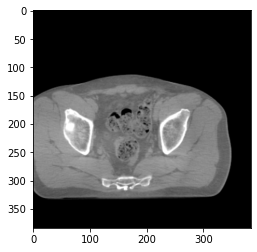

In [22]:
plt.imshow(x.squeeze(), 'gray'),

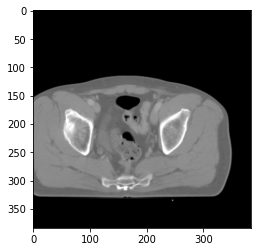

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

112it [02:10,  1.16s/it]
112it [00:34,  3.21it/s]
16it [00:05,  2.95it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.18it/s]
16it [00:05,  2.92it/s]
112it [02:10,  1.16s/it]
112it [00:35,  3.17it/s]
16it [00:05,  2.92it/s]
112it [02:10,  1.16s/it]
112it [00:35,  3.18it/s]
16it [00:05,  2.92it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.16it/s]
16it [00:05,  2.92it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.17it/s]
16it [00:05,  2.92it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.18it/s]
16it [00:05,  2.93it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.17it/s]
16it [00:05,  2.91it/s]
112it [02:10,  1.16s/it]
112it [00:35,  3.17it/s]
16it [00:05,  2.92it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.18it/s]
16it [00:05,  2.92it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.15it/s]
16it [00:05,  2.93it/s]
112it [02:09,  1.16s/it]
112it [00:35,  3.16it/s]
16it [00:05,  2.92it/s]
112it [02:10,  1.16s/it]
112it [00:35,  3.17it/s]
16it [00:05,  2.92it/s]
112it [02:10,  1.16s/it]
112it [00:35,

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8956177234649658
psnr score = 26.0169620513916
snr score = 16.07990074157715
mae error = 0.016610538586974144
air dice score = 0.9983032577451311
bone dice score = 0.9424159330359011


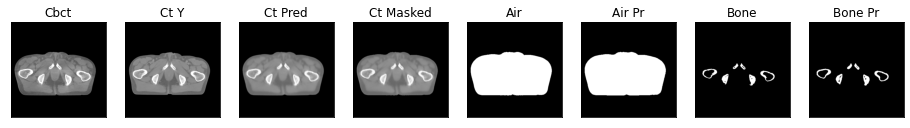

ssim score = 0.8962572813034058
psnr score = 25.99388313293457
snr score = 16.10435676574707
mae error = 0.016786731779575348
air dice score = 0.9985937266244467
bone dice score = 0.9346433148236559


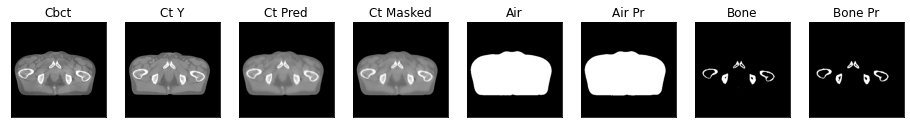

ssim score = 0.894661545753479
psnr score = 25.88385772705078
snr score = 16.157228469848633
mae error = 0.01781334914267063
air dice score = 0.9989615784008318
bone dice score = 0.9359923572971579


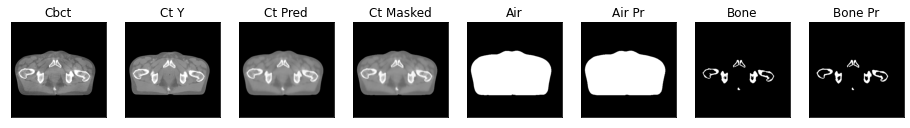

ssim score = 0.8924089670181274
psnr score = 25.99747657775879
snr score = 16.36009979248047
mae error = 0.01773720048367977
air dice score = 0.9986599731994653
bone dice score = 0.927370689655955


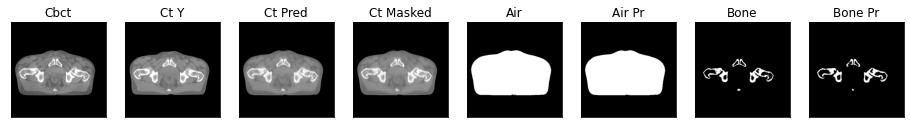

ssim score = 0.8919262290000916
psnr score = 26.180622100830078
snr score = 16.58354949951172
mae error = 0.017383122816681862
air dice score = 0.9985354599257713
bone dice score = 0.9235099980593718


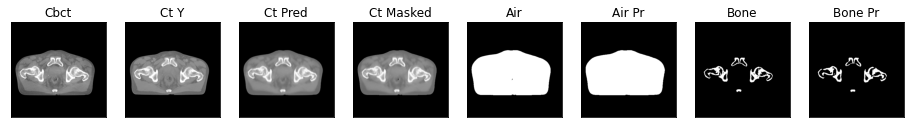

ssim score = 0.88611900806427
psnr score = 26.017227172851562
snr score = 16.556686401367188
mae error = 0.01801002398133278
air dice score = 0.9986906248740999
bone dice score = 0.9229618548996679


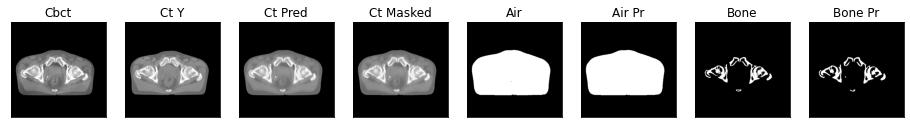

ssim score = 0.8826712965965271
psnr score = 25.686616897583008
snr score = 16.202016830444336
mae error = 0.018602516502141953
air dice score = 0.9981945796819233
bone dice score = 0.926676817053236


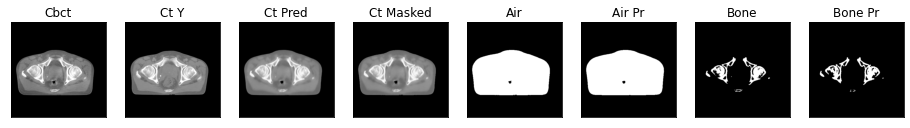

ssim score = 0.8851650357246399
psnr score = 26.100847244262695
snr score = 16.430713653564453
mae error = 0.017645955085754395
air dice score = 0.9984388551604526
bone dice score = 0.9326863696521157


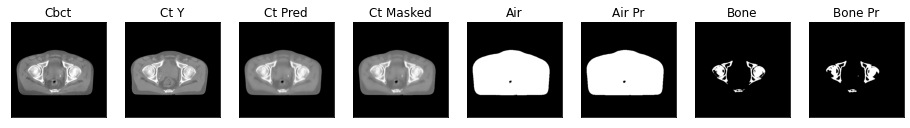

ssim score = 0.8885486721992493
psnr score = 26.494905471801758
snr score = 16.730215072631836
mae error = 0.016984453424811363
air dice score = 0.9985332882037411
bone dice score = 0.9437727883329133


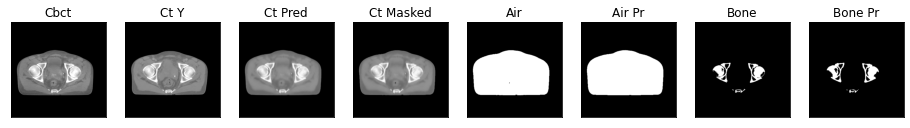

ssim score = 0.8921964168548584
psnr score = 26.54494285583496
snr score = 16.764968872070312
mae error = 0.01682686246931553
air dice score = 0.9986038574900474
bone dice score = 0.9340824721587832


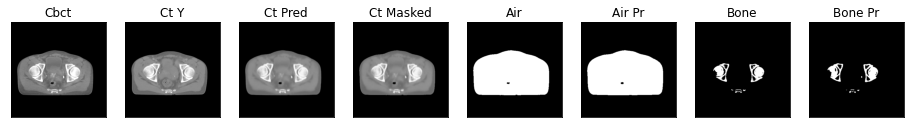

ssim score = 0.8986748456954956
psnr score = 26.871299743652344
snr score = 17.12359619140625
mae error = 0.01640983857214451
air dice score = 0.998626230668361
bone dice score = 0.9521601685990289


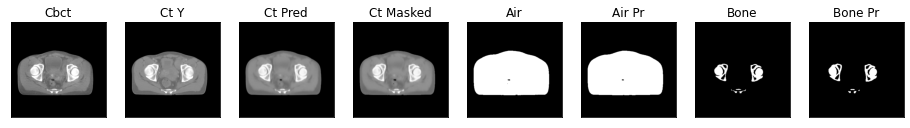

ssim score = 0.8987683653831482
psnr score = 26.011648178100586
snr score = 16.287654876708984
mae error = 0.01752612739801407
air dice score = 0.9983679228396054
bone dice score = 0.956004250797492


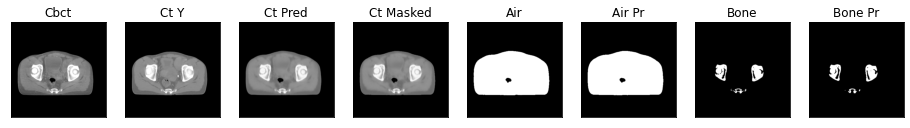

1it [00:04,  4.47s/it]

ssim score = 0.9039750695228577
psnr score = 25.332700729370117
snr score = 15.576784133911133
mae error = 0.01824246533215046
air dice score = 0.9984980666602771
bone dice score = 0.9662485746868159


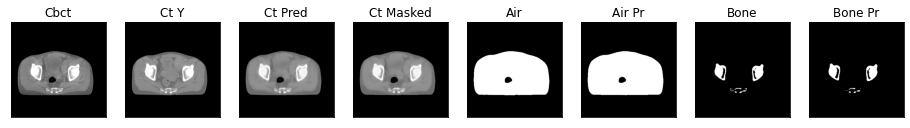

ssim score = 0.9007532596588135
psnr score = 25.13046646118164
snr score = 15.232593536376953
mae error = 0.018100297078490257
air dice score = 0.9983781751785635
bone dice score = 0.9401084352548215


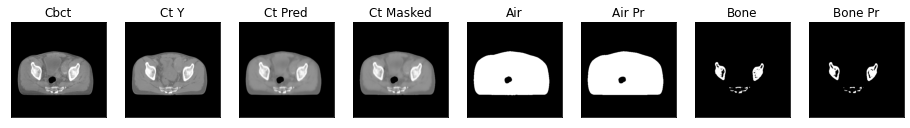

ssim score = 0.8986921310424805
psnr score = 25.05202865600586
snr score = 15.06849479675293
mae error = 0.018177973106503487
air dice score = 0.9983341266063798
bone dice score = 0.9156304318770473


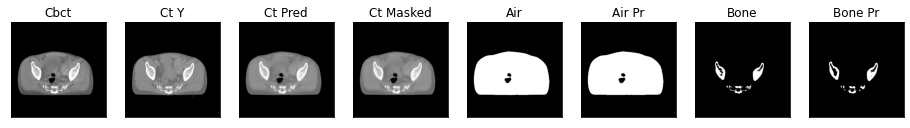

ssim score = 0.8927688002586365
psnr score = 24.794130325317383
snr score = 14.83407974243164
mae error = 0.018906721845269203
air dice score = 0.9984242384724911
bone dice score = 0.9275949367097773


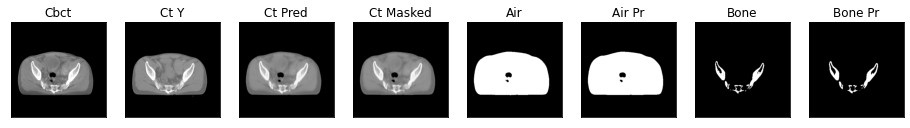

ssim score = 0.8896970748901367
psnr score = 24.04218864440918
snr score = 14.079597473144531
mae error = 0.020397305488586426
air dice score = 0.9987016130806995
bone dice score = 0.9300274168562399


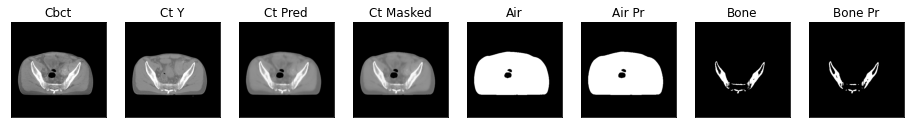

ssim score = 0.8826780915260315
psnr score = 23.406543731689453
snr score = 13.342191696166992
mae error = 0.021605517715215683
air dice score = 0.9977135591519003
bone dice score = 0.9106445312510907


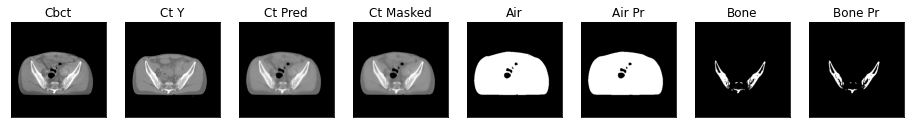

ssim score = 0.8799335360527039
psnr score = 23.13321876525879
snr score = 13.018183708190918
mae error = 0.022019710391759872
air dice score = 0.997500168907509
bone dice score = 0.9129256509966662


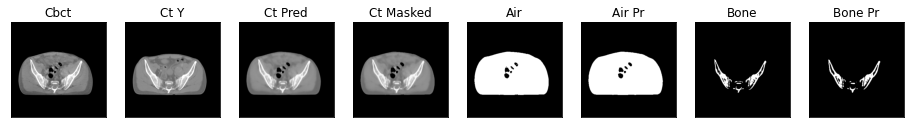

ssim score = 0.8824853301048279
psnr score = 23.19400405883789
snr score = 13.066658020019531
mae error = 0.02198108285665512
air dice score = 0.9976226594516294
bone dice score = 0.9185793669978426


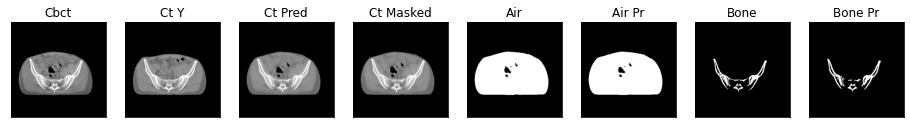

ssim score = 0.8802153468132019
psnr score = 23.115909576416016
snr score = 12.923717498779297
mae error = 0.022215954959392548
air dice score = 0.9979035161679946
bone dice score = 0.9047367028326974


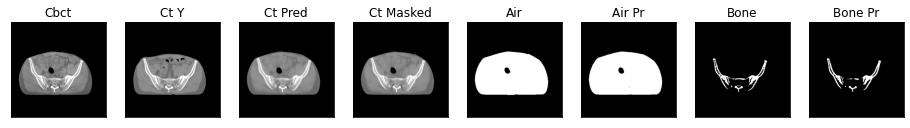

ssim score = 0.8784415125846863
psnr score = 23.134605407714844
snr score = 12.88298511505127
mae error = 0.02171970345079899
air dice score = 0.9975701601851773
bone dice score = 0.9201841903310286


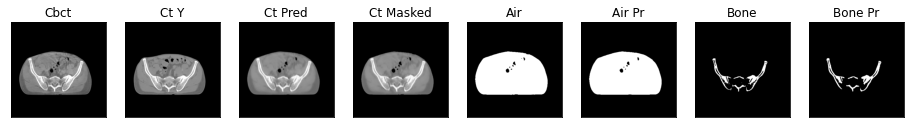

ssim score = 0.881514310836792
psnr score = 23.304508209228516
snr score = 13.019460678100586
mae error = 0.02123994193971157
air dice score = 0.9979132370330892
bone dice score = 0.9259834987453547


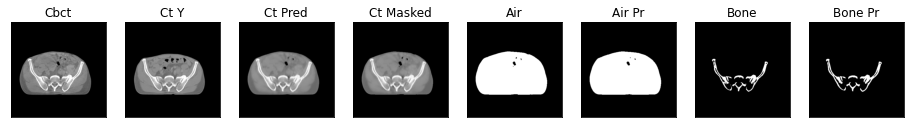

ssim score = 0.8820917010307312
psnr score = 23.367664337158203
snr score = 13.034052848815918
mae error = 0.021286243572831154
air dice score = 0.9977388553687567
bone dice score = 0.9197197657066759


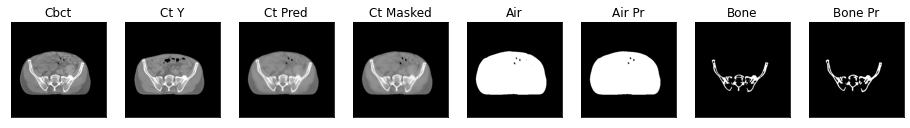

2it [00:08,  4.23s/it]

ssim score = 0.8816921710968018
psnr score = 23.230064392089844
snr score = 12.79945182800293
mae error = 0.021571284160017967
air dice score = 0.9980883173630676
bone dice score = 0.9256381798010473


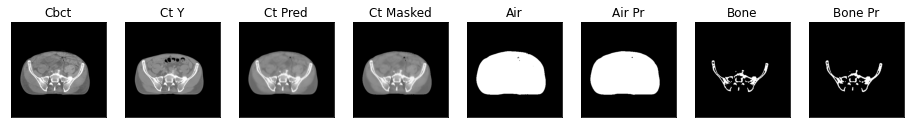

ssim score = 0.885582685470581
psnr score = 23.397621154785156
snr score = 12.88427448272705
mae error = 0.021021945402026176
air dice score = 0.997671146475186
bone dice score = 0.9040727027947484


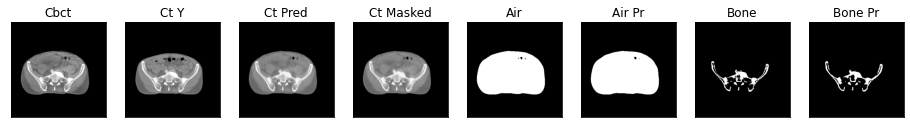

ssim score = 0.8856414556503296
psnr score = 23.462203979492188
snr score = 12.857671737670898
mae error = 0.02109430357813835
air dice score = 0.9973634371866793
bone dice score = 0.9087901180113732


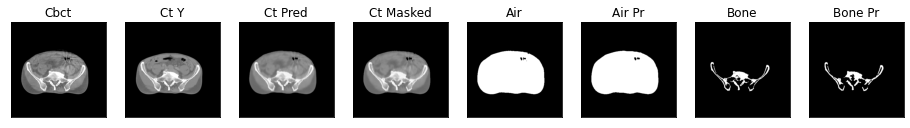

ssim score = 0.8869408369064331
psnr score = 23.313678741455078
snr score = 12.668039321899414
mae error = 0.021374670788645744
air dice score = 0.997069587855772
bone dice score = 0.9161720295749644


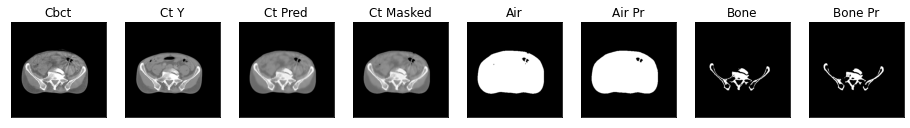

ssim score = 0.8720585107803345
psnr score = 24.168148040771484
snr score = 15.540304183959961
mae error = 0.02116853930056095
air dice score = 0.9987685575871238
bone dice score = 0.9766708701142285


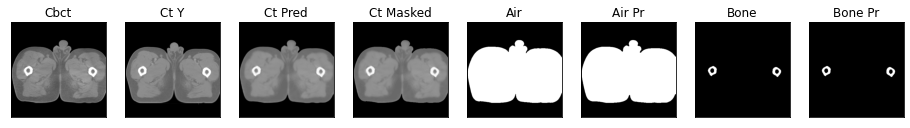

ssim score = 0.8769978880882263
psnr score = 24.780866622924805
snr score = 16.192283630371094
mae error = 0.01994176022708416
air dice score = 0.9988661077755272
bone dice score = 0.9717480871108962


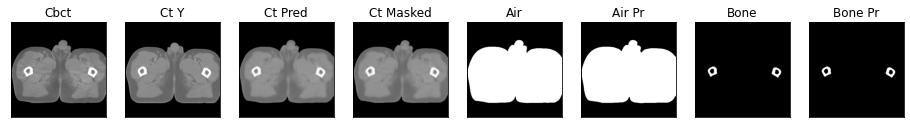

ssim score = 0.8842518329620361
psnr score = 25.317703247070312
snr score = 16.816566467285156
mae error = 0.01903221383690834
air dice score = 0.9989729839428814
bone dice score = 0.9646892655375544


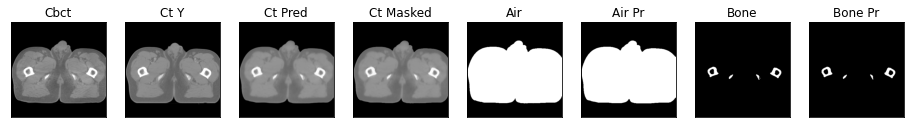

ssim score = 0.8888161182403564
psnr score = 25.748212814331055
snr score = 17.409631729125977
mae error = 0.01887013390660286
air dice score = 0.9984668291461286
bone dice score = 0.9656721206293604


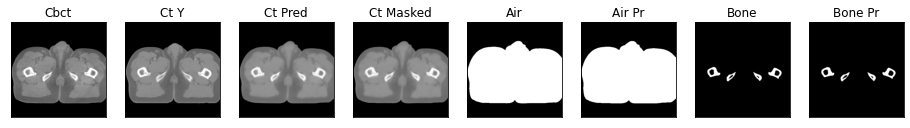

ssim score = 0.8904905319213867
psnr score = 26.04418182373047
snr score = 17.833744049072266
mae error = 0.018701964989304543
air dice score = 0.9983153413410379
bone dice score = 0.9500619067278847


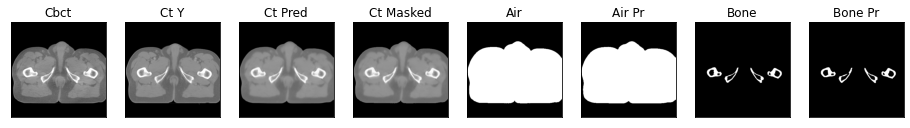

ssim score = 0.8921446204185486
psnr score = 26.50473403930664
snr score = 18.39753532409668
mae error = 0.018320372328162193
air dice score = 0.9984555844250241
bone dice score = 0.9397273379581471


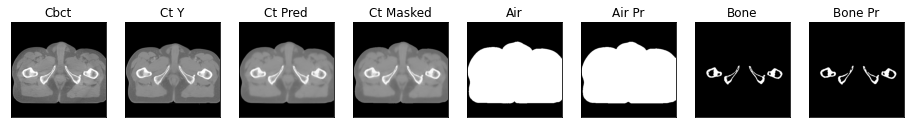

ssim score = 0.8927289843559265
psnr score = 26.840974807739258
snr score = 18.80087661743164
mae error = 0.018470916897058487
air dice score = 0.9985398112615557
bone dice score = 0.9305189094114938


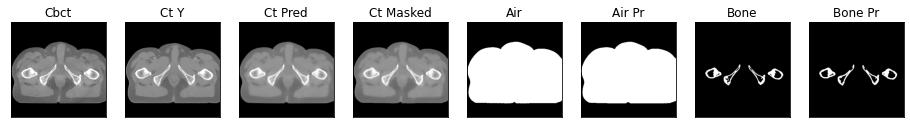

ssim score = 0.8918189406394958
psnr score = 26.88096809387207
snr score = 18.83098030090332
mae error = 0.01821100153028965
air dice score = 0.9985264664665877
bone dice score = 0.947041787340225


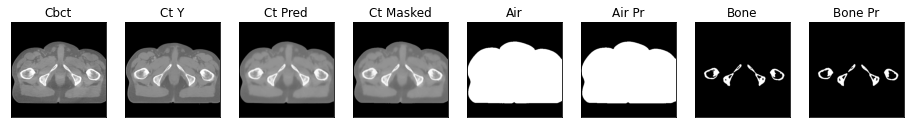

3it [00:11,  4.07s/it]

ssim score = 0.8940797448158264
psnr score = 27.012311935424805
snr score = 18.94866180419922
mae error = 0.017895538359880447
air dice score = 0.9984272576656191
bone dice score = 0.9529326574950561


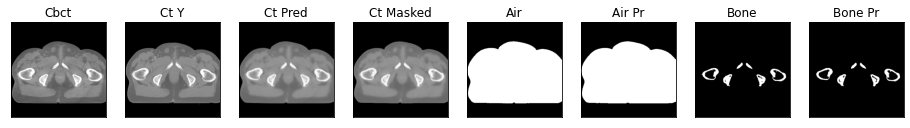

ssim score = 0.8948937058448792
psnr score = 27.078521728515625
snr score = 19.026870727539062
mae error = 0.01812446303665638
air dice score = 0.9983095957416209
bone dice score = 0.9374106258944296


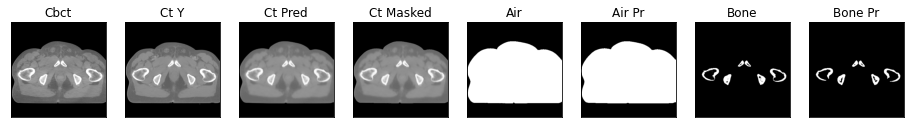

ssim score = 0.8957257866859436
psnr score = 27.118362426757812
snr score = 19.10579490661621
mae error = 0.018047315999865532
air dice score = 0.9985321342767625
bone dice score = 0.9443571909362312


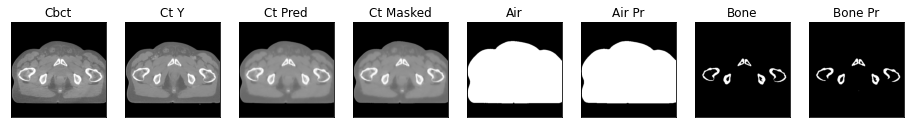

ssim score = 0.8935093283653259
psnr score = 27.06327247619629
snr score = 19.191993713378906
mae error = 0.018621904775500298
air dice score = 0.9985558917817667
bone dice score = 0.9468958930282054


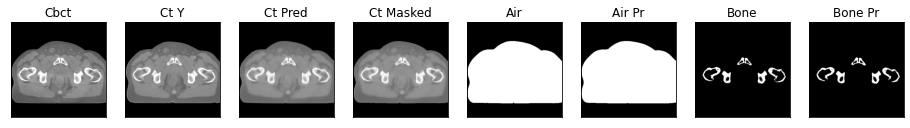

ssim score = 0.8920372128486633
psnr score = 27.147953033447266
snr score = 19.37136459350586
mae error = 0.018785519525408745
air dice score = 0.9984339279606871
bone dice score = 0.9435189592262135


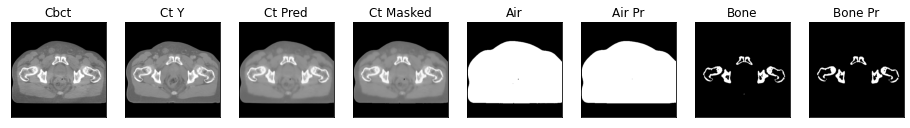

ssim score = 0.883427083492279
psnr score = 26.365604400634766
snr score = 18.554967880249023
mae error = 0.02045338973402977
air dice score = 0.9981261109270038
bone dice score = 0.9272249690982136


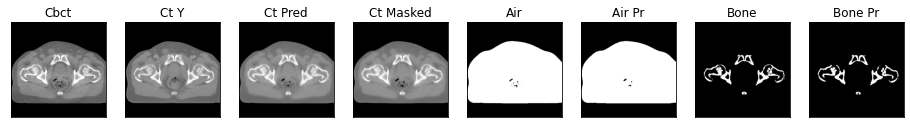

ssim score = 0.8806086182594299
psnr score = 25.65058708190918
snr score = 17.912137985229492
mae error = 0.021154241636395454
air dice score = 0.9976450594804579
bone dice score = 0.9115932203395825


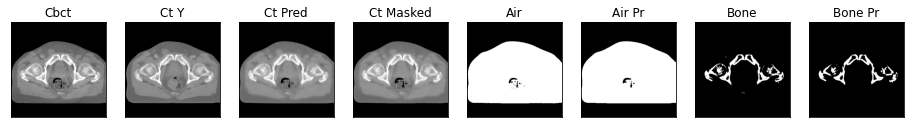

ssim score = 0.8774162530899048
psnr score = 25.685985565185547
snr score = 17.81144142150879
mae error = 0.021007107570767403
air dice score = 0.997851347320881
bone dice score = 0.8994237820857393


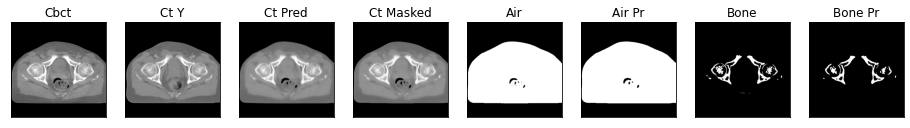

ssim score = 0.8825454115867615
psnr score = 25.869651794433594
snr score = 17.81654167175293
mae error = 0.019978268072009087
air dice score = 0.9982733690048393
bone dice score = 0.8856428214118495


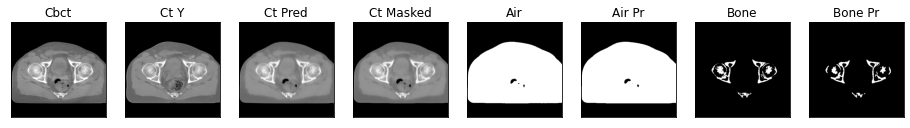

ssim score = 0.8834028840065002
psnr score = 26.051067352294922
snr score = 17.907373428344727
mae error = 0.019950740039348602
air dice score = 0.9983876287148677
bone dice score = 0.8657155797116652


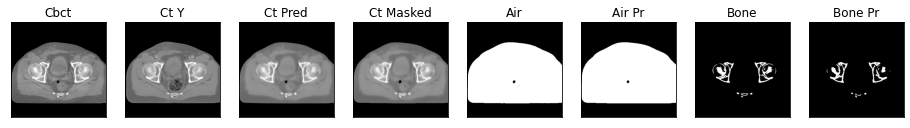

ssim score = 0.8835019469261169
psnr score = 25.94745635986328
snr score = 17.81945037841797
mae error = 0.019903864711523056
air dice score = 0.9983510791543314
bone dice score = 0.8840151834681146


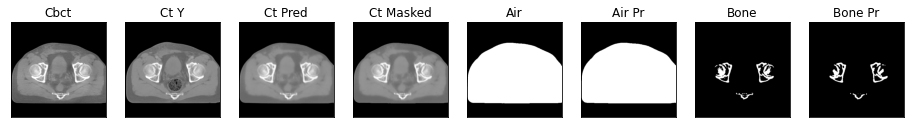

ssim score = 0.8735135197639465
psnr score = 25.831396102905273
snr score = 17.713428497314453
mae error = 0.021012363955378532
air dice score = 0.9983728813559332
bone dice score = 0.9033401754067611


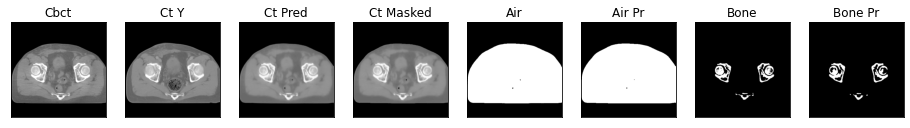

4it [00:15,  3.96s/it]

ssim score = 0.8824114799499512
psnr score = 26.17652702331543
snr score = 18.120149612426758
mae error = 0.020322270691394806
air dice score = 0.9982618162473799
bone dice score = 0.9357331151719323


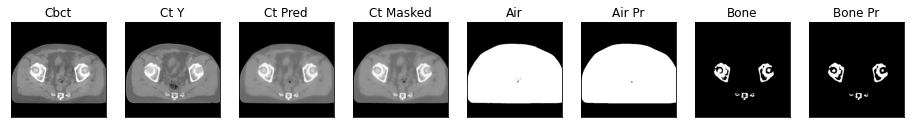

ssim score = 0.8835941553115845
psnr score = 26.66019058227539
snr score = 18.673892974853516
mae error = 0.020138273015618324
air dice score = 0.9981145649854882
bone dice score = 0.957500654507745


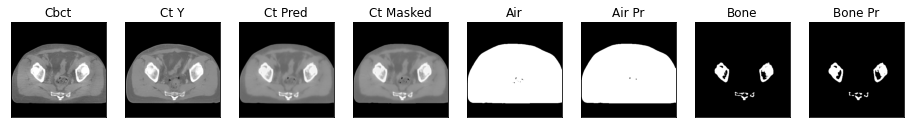

ssim score = 0.8815181255340576
psnr score = 26.128084182739258
snr score = 18.022682189941406
mae error = 0.020599720999598503
air dice score = 0.998120452332067
bone dice score = 0.9386189258318058


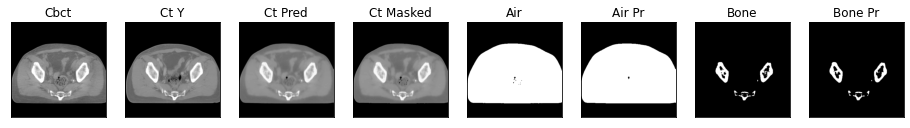

ssim score = 0.8762999176979065
psnr score = 25.503429412841797
snr score = 17.479652404785156
mae error = 0.022322405129671097
air dice score = 0.9982192163310903
bone dice score = 0.9517194646793857


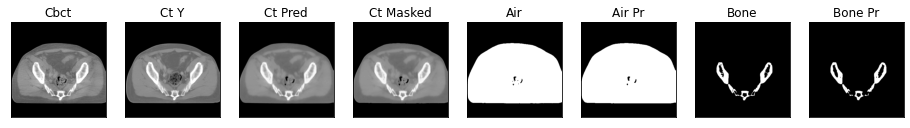

ssim score = 0.8749228119850159
psnr score = 25.53274154663086
snr score = 17.589113235473633
mae error = 0.022643527016043663
air dice score = 0.998096678797499
bone dice score = 0.9433261955749941


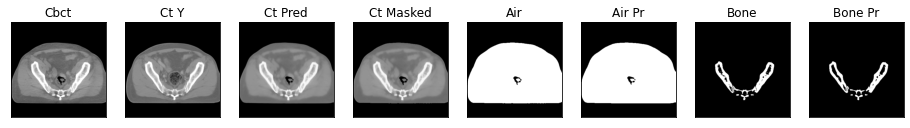

ssim score = 0.8628087639808655
psnr score = 24.964820861816406
snr score = 17.042749404907227
mae error = 0.02469174936413765
air dice score = 0.9983441048898346
bone dice score = 0.9354861553718895


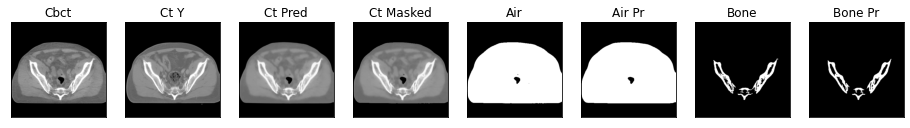

ssim score = 0.8647104501724243
psnr score = 25.50110626220703
snr score = 17.591571807861328
mae error = 0.02393227443099022
air dice score = 0.9982471408783918
bone dice score = 0.9481047897783703


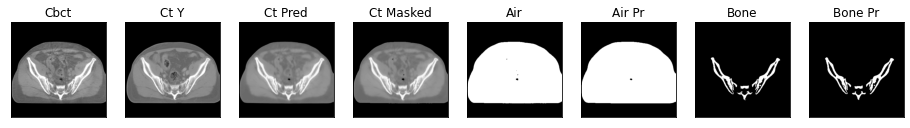

ssim score = 0.8197304010391235
psnr score = 21.285703659057617
snr score = 11.165912628173828
mae error = 0.03220190480351448
air dice score = 0.985061649600887
bone dice score = 0.961886482041078


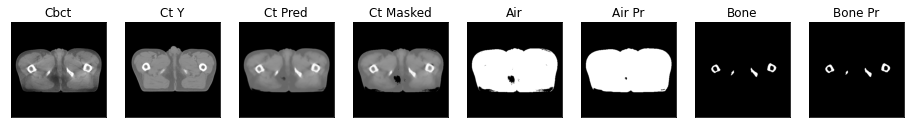

ssim score = 0.8080981373786926
psnr score = 20.9129638671875
snr score = 11.00615119934082
mae error = 0.03470047935843468
air dice score = 0.9872332580541207
bone dice score = 0.9336587530522819


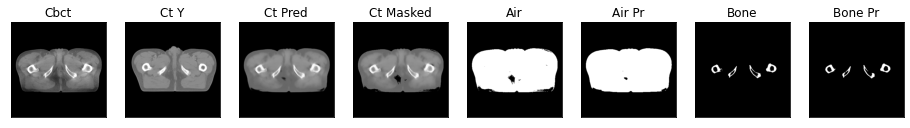

ssim score = 0.804289698600769
psnr score = 20.942134857177734
snr score = 11.166462898254395
mae error = 0.034964416176080704
air dice score = 0.9863900065071474
bone dice score = 0.9013059302097772


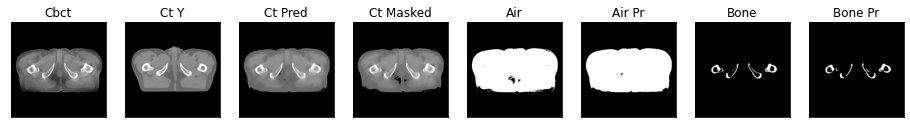

ssim score = 0.807725727558136
psnr score = 21.243677139282227
snr score = 11.538406372070312
mae error = 0.03395988792181015
air dice score = 0.985995579482207
bone dice score = 0.903041437029944


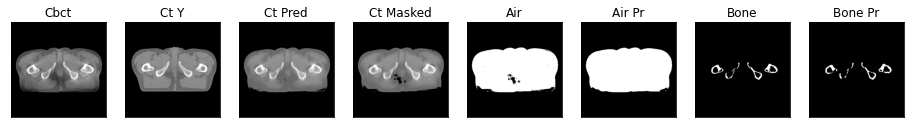

ssim score = 0.8084077835083008
psnr score = 21.216705322265625
snr score = 11.559000968933105
mae error = 0.0339585579931736
air dice score = 0.9880674804553669
bone dice score = 0.8887995173961633


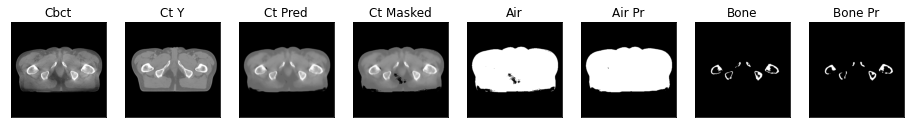

5it [00:19,  3.88s/it]

ssim score = 0.8120775818824768
psnr score = 21.438865661621094
snr score = 11.786776542663574
mae error = 0.033106110990047455
air dice score = 0.9876023263870011
bone dice score = 0.8900383141783518


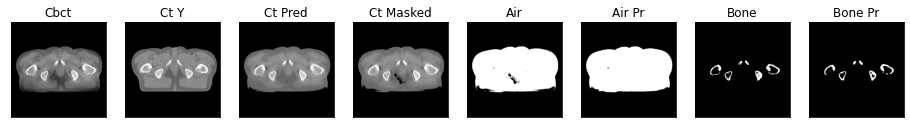

ssim score = 0.816213846206665
psnr score = 21.607410430908203
snr score = 11.948820114135742
mae error = 0.03235868737101555
air dice score = 0.9885132619612007
bone dice score = 0.9193487315426099


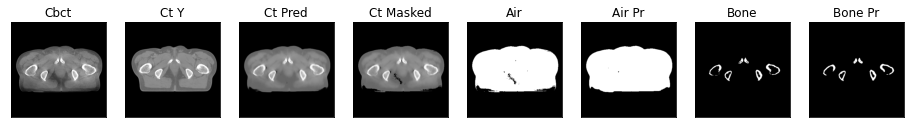

ssim score = 0.8164411783218384
psnr score = 21.526487350463867
snr score = 11.882007598876953
mae error = 0.032474417239427567
air dice score = 0.9902968706279592
bone dice score = 0.9275150629920118


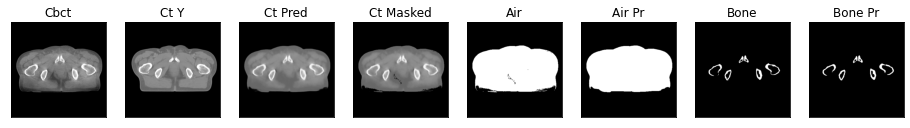

ssim score = 0.8147527575492859
psnr score = 21.50347137451172
snr score = 11.916999816894531
mae error = 0.033147864043712616
air dice score = 0.990363525223841
bone dice score = 0.9062082777051701


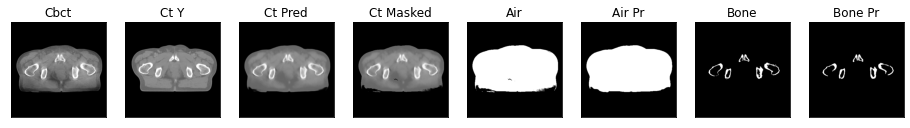

ssim score = 0.8059757947921753
psnr score = 21.3200740814209
snr score = 11.832159042358398
mae error = 0.03482447564601898
air dice score = 0.9910493854869054
bone dice score = 0.8780329990314133


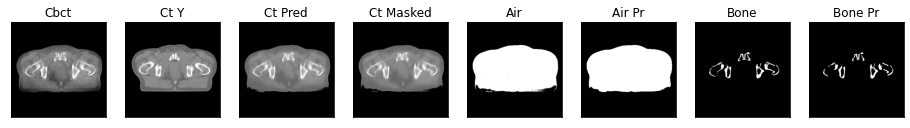

ssim score = 0.79366534948349
psnr score = 21.144794464111328
snr score = 11.692709922790527
mae error = 0.03622753918170929
air dice score = 0.9900291153415542
bone dice score = 0.876190476192378


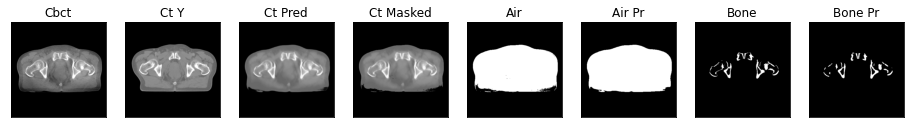

ssim score = 0.7830228805541992
psnr score = 21.029661178588867
snr score = 11.610283851623535
mae error = 0.03636254370212555
air dice score = 0.9899965135301937
bone dice score = 0.8501444887869802


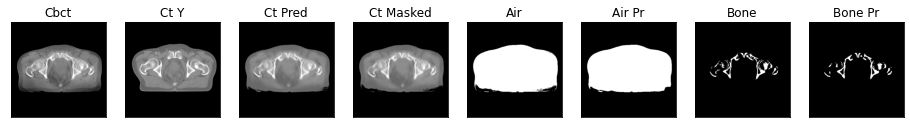

ssim score = 0.7842317819595337
psnr score = 20.980690002441406
snr score = 11.678128242492676
mae error = 0.03704085201025009
air dice score = 0.989482330672676
bone dice score = 0.8384647827943419


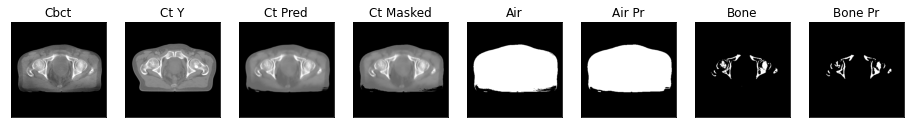

ssim score = 0.7885937690734863
psnr score = 20.868261337280273
snr score = 11.549713134765625
mae error = 0.03735889866948128
air dice score = 0.98762480036404
bone dice score = 0.8388810751705129


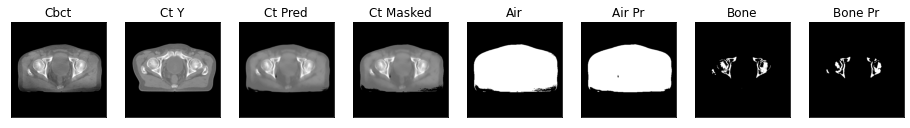

ssim score = 0.8037481307983398
psnr score = 21.45867347717285
snr score = 11.940961837768555
mae error = 0.033826954662799835
air dice score = 0.9865855616404265
bone dice score = 0.8739662586855116


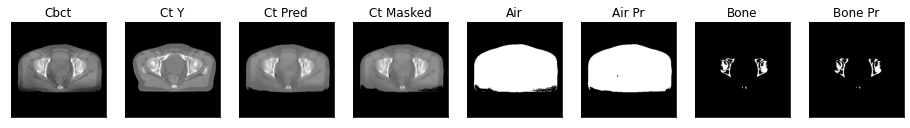

ssim score = 0.8190432786941528
psnr score = 22.173431396484375
snr score = 12.48532485961914
mae error = 0.030641112476587296
air dice score = 0.9855521155830882
bone dice score = 0.9044758185655681


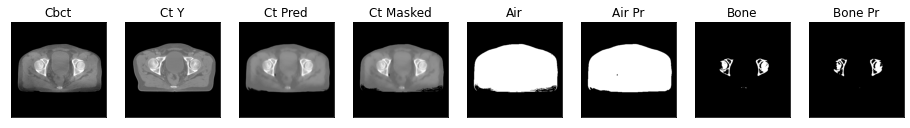

ssim score = 0.8254626989364624
psnr score = 22.440433502197266
snr score = 12.766498565673828
mae error = 0.02962704561650753
air dice score = 0.9859375695774272
bone dice score = 0.9207308696260375


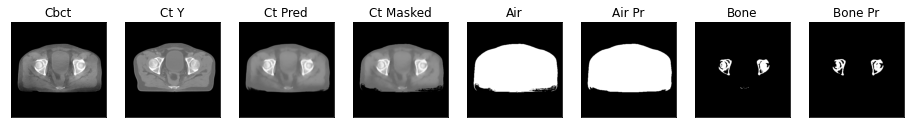

6it [00:22,  3.82s/it]

ssim score = 0.8289210200309753
psnr score = 22.541685104370117
snr score = 12.949577331542969
mae error = 0.02959347516298294
air dice score = 0.9869210538046744
bone dice score = 0.940837336994635


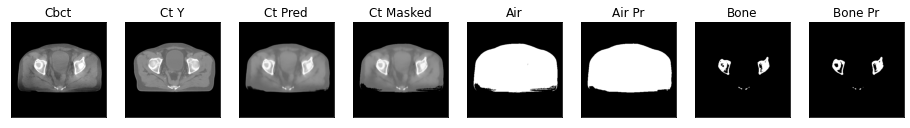

ssim score = 0.8279752731323242
psnr score = 22.328975677490234
snr score = 12.82904052734375
mae error = 0.030695641413331032
air dice score = 0.9857878145648312
bone dice score = 0.9231009690540309


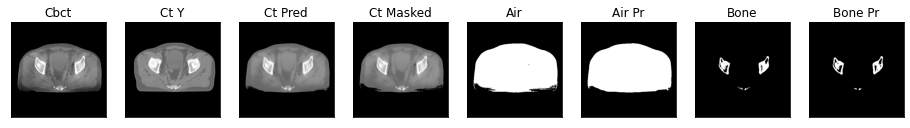

ssim score = 0.8258805871009827
psnr score = 22.707748413085938
snr score = 13.144387245178223
mae error = 0.029256105422973633
air dice score = 0.9856246525295973
bone dice score = 0.9229968782531565


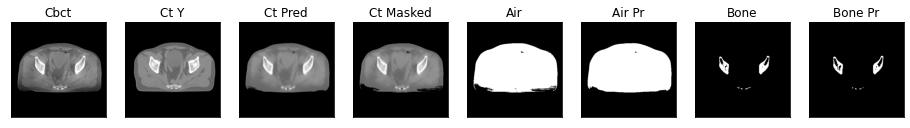

ssim score = 0.8310738205909729
psnr score = 22.924196243286133
snr score = 13.324442863464355
mae error = 0.02813039906322956
air dice score = 0.9848917062863313
bone dice score = 0.9323922734039303


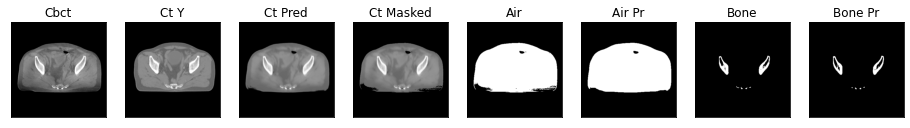

ssim score = 0.8266493082046509
psnr score = 22.717025756835938
snr score = 13.155016899108887
mae error = 0.02954084426164627
air dice score = 0.9847181334856675
bone dice score = 0.9112917171033842


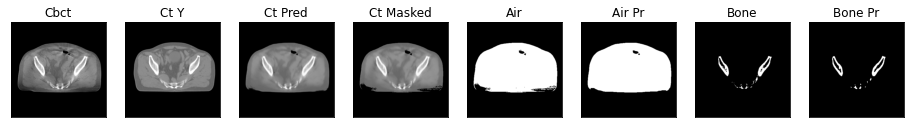

ssim score = 0.8207512497901917
psnr score = 22.61838722229004
snr score = 13.186882019042969
mae error = 0.030444523319602013
air dice score = 0.9846710012547626
bone dice score = 0.9194562198520764


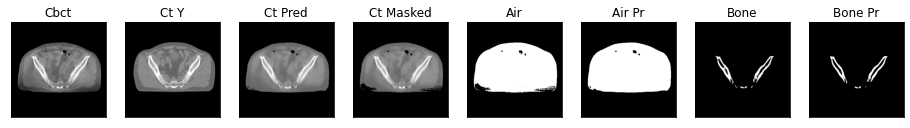

ssim score = 0.8222949504852295
psnr score = 22.61418914794922
snr score = 13.200431823730469
mae error = 0.030177593231201172
air dice score = 0.9848422200913295
bone dice score = 0.8978125000015966


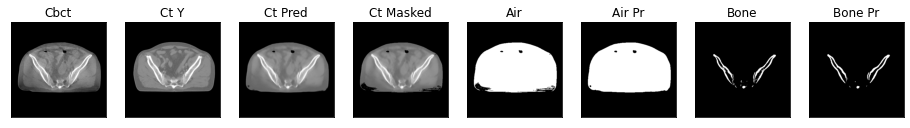

ssim score = 0.8243866562843323
psnr score = 23.005908966064453
snr score = 13.580886840820312
mae error = 0.02913481928408146
air dice score = 0.985606180875284
bone dice score = 0.9118876442081276


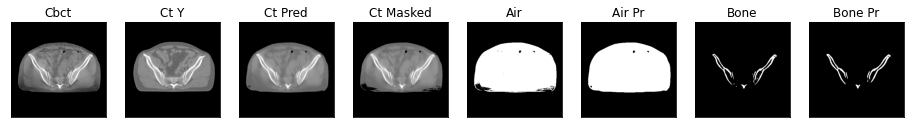

ssim score = 0.8263857960700989
psnr score = 23.08108901977539
snr score = 13.65532112121582
mae error = 0.02868848480284214
air dice score = 0.9851377412905526
bone dice score = 0.8922413793121313


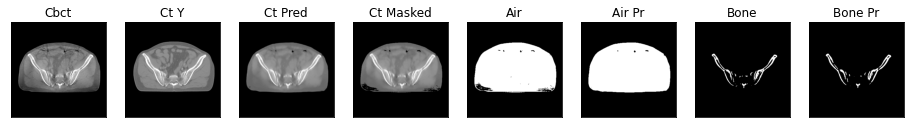

ssim score = 0.885017454624176
psnr score = 24.839393615722656
snr score = 15.273529052734375
mae error = 0.019270865246653557
air dice score = 0.9988234346039174
bone dice score = 0.9526376588389435


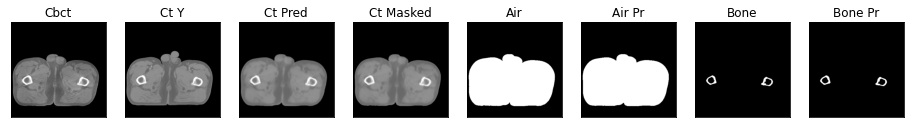

ssim score = 0.8824915885925293
psnr score = 25.043060302734375
snr score = 15.541587829589844
mae error = 0.019209418445825577
air dice score = 0.9986372090040414
bone dice score = 0.930447125623476


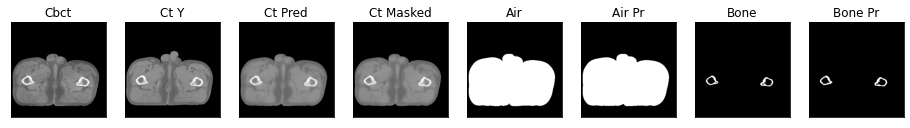

ssim score = 0.8880871534347534
psnr score = 26.655292510986328
snr score = 17.29302978515625
mae error = 0.018125085160136223
air dice score = 0.9982092201391435
bone dice score = 0.9418737178039236


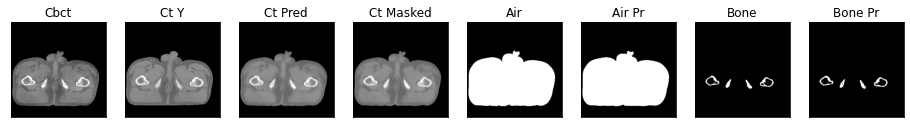

7it [00:26,  3.78s/it]

ssim score = 0.8889129161834717
psnr score = 26.48707389831543
snr score = 17.24630355834961
mae error = 0.018712736666202545
air dice score = 0.9986530872657682
bone dice score = 0.9213434452888116


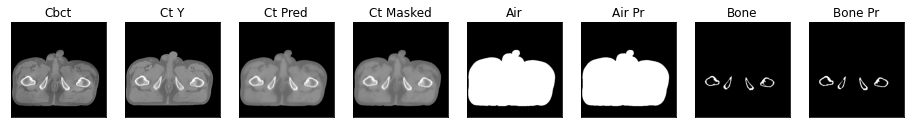

ssim score = 0.8851842284202576
psnr score = 26.252710342407227
snr score = 17.036115646362305
mae error = 0.018954264000058174
air dice score = 0.9986484575128486
bone dice score = 0.89988700565198


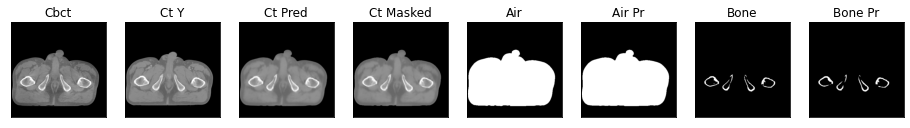

ssim score = 0.8855661749839783
psnr score = 26.094768524169922
snr score = 16.873775482177734
mae error = 0.01901569403707981
air dice score = 0.9987759713765624
bone dice score = 0.8898641588319778


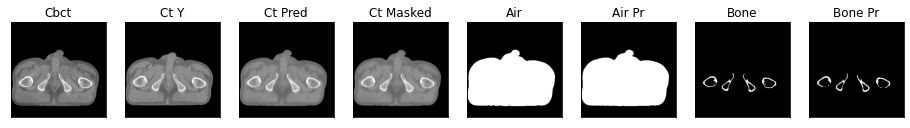

ssim score = 0.8870485424995422
psnr score = 25.61102867126465
snr score = 16.396289825439453
mae error = 0.019612543284893036
air dice score = 0.9985180306273682
bone dice score = 0.8843648208492597


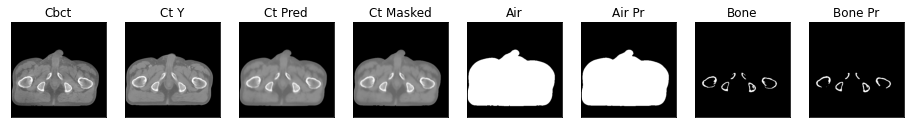

ssim score = 0.8844255208969116
psnr score = 25.31346321105957
snr score = 16.077167510986328
mae error = 0.019719192758202553
air dice score = 0.9987441130298284
bone dice score = 0.9009508716342918


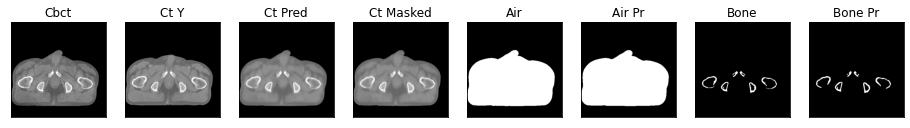

ssim score = 0.8860665559768677
psnr score = 25.411773681640625
snr score = 16.1923885345459
mae error = 0.019377807155251503
air dice score = 0.9987322934465093
bone dice score = 0.9126533601920408


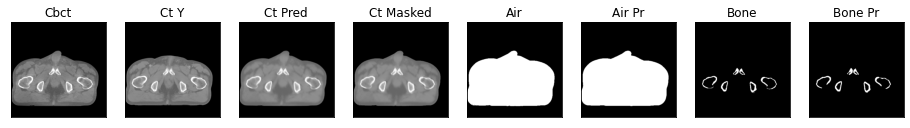

ssim score = 0.8866870999336243
psnr score = 25.731903076171875
snr score = 16.581111907958984
mae error = 0.01917090453207493
air dice score = 0.9989175009284216
bone dice score = 0.9080751650599614


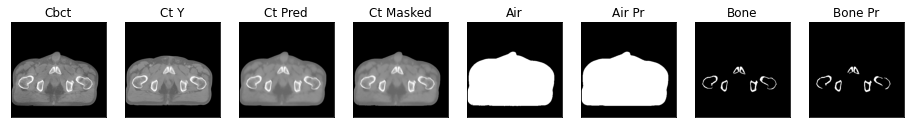

ssim score = 0.886960506439209
psnr score = 26.187637329101562
snr score = 17.11820411682129
mae error = 0.018829287961125374
air dice score = 0.9988892591358445
bone dice score = 0.9073231927253046


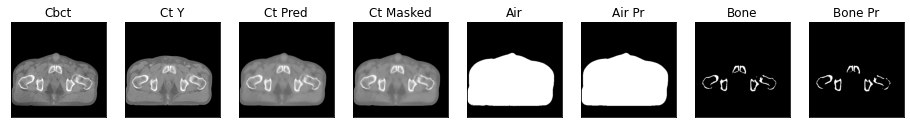

ssim score = 0.8882447481155396
psnr score = 26.618362426757812
snr score = 17.599632263183594
mae error = 0.018565122038125992
air dice score = 0.9989485925477523
bone dice score = 0.873903840340582


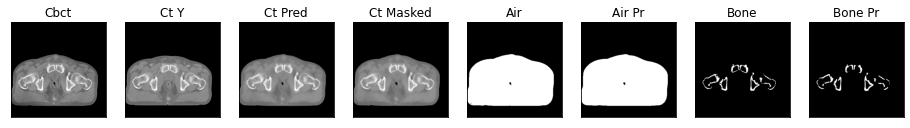

ssim score = 0.8901101350784302
psnr score = 26.982995986938477
snr score = 18.080533981323242
mae error = 0.018353678286075592
air dice score = 0.9986739731279867
bone dice score = 0.8587780798417688


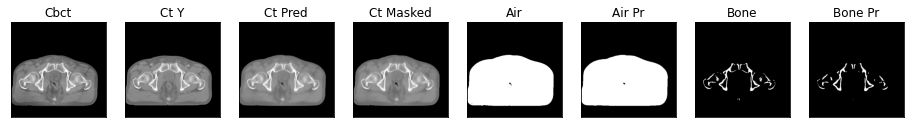

ssim score = 0.8892748355865479
psnr score = 26.674114227294922
snr score = 17.733417510986328
mae error = 0.018366524949669838
air dice score = 0.9986415555394804
bone dice score = 0.8331038702794386


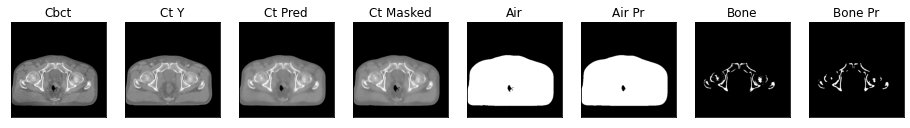

ssim score = 0.8839002847671509
psnr score = 25.846435546875
snr score = 16.810068130493164
mae error = 0.019077356904745102
air dice score = 0.9981810799837612
bone dice score = 0.8116151401356311


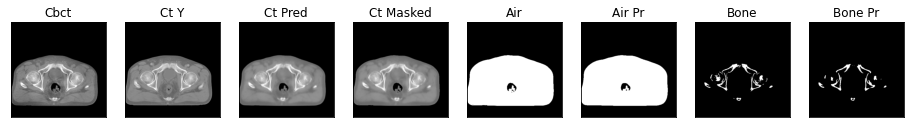

8it [00:30,  3.76s/it]

ssim score = 0.8868882060050964
psnr score = 25.552791595458984
snr score = 16.35666847229004
mae error = 0.019130591303110123
air dice score = 0.9977674372960658
bone dice score = 0.8212439850325923


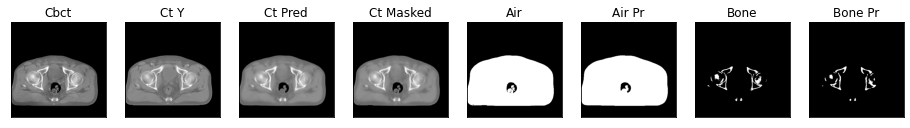

ssim score = 0.8853327035903931
psnr score = 25.168964385986328
snr score = 15.856414794921875
mae error = 0.019297795370221138
air dice score = 0.9981654408726567
bone dice score = 0.8227894931590309


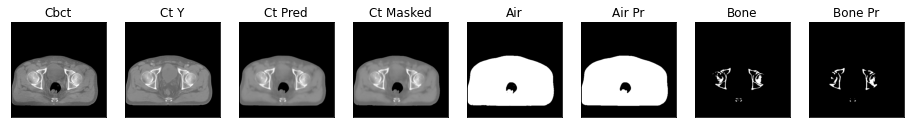

ssim score = 0.8837047815322876
psnr score = 25.09544563293457
snr score = 15.737801551818848
mae error = 0.019075701013207436
air dice score = 0.9981455147236167
bone dice score = 0.8615857826407795


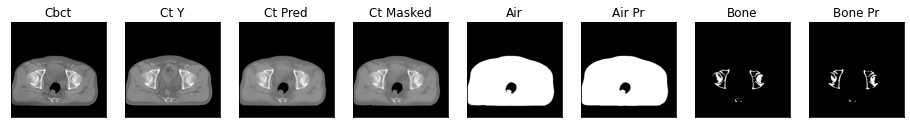

ssim score = 0.8774683475494385
psnr score = 24.390369415283203
snr score = 15.039397239685059
mae error = 0.020699426531791687
air dice score = 0.9979335399793371
bone dice score = 0.9042448173757117


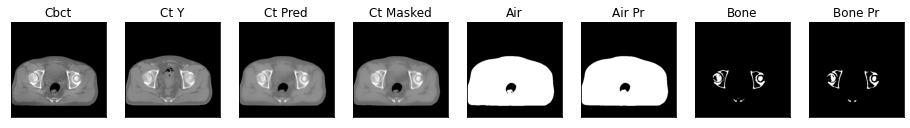

ssim score = 0.8796488642692566
psnr score = 23.976093292236328
snr score = 14.655223846435547
mae error = 0.021803343668580055
air dice score = 0.9979709927106052
bone dice score = 0.9289914066044175


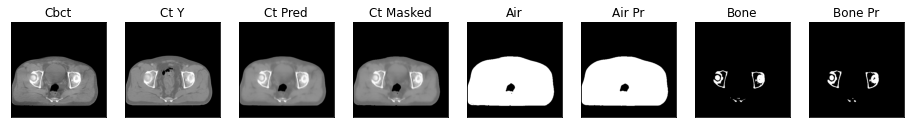

ssim score = 0.8867736458778381
psnr score = 24.652956008911133
snr score = 15.289501190185547
mae error = 0.020297808572649956
air dice score = 0.9976398375407627
bone dice score = 0.9236524400625122


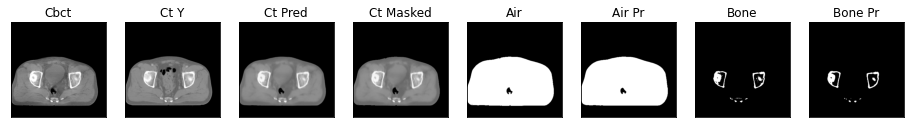

ssim score = 0.8884157538414001
psnr score = 24.91511344909668
snr score = 15.461453437805176
mae error = 0.0192608330398798
air dice score = 0.9980592919761777
bone dice score = 0.9120307988467367


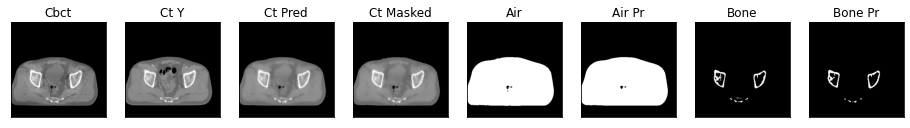

ssim score = 0.8884629607200623
psnr score = 24.56481170654297
snr score = 15.045431137084961
mae error = 0.019758475944399834
air dice score = 0.9982854584920495
bone dice score = 0.9258077383341482


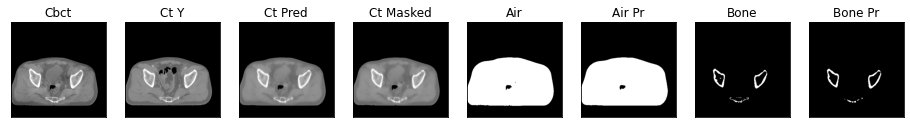

ssim score = 0.8863562345504761
psnr score = 24.689159393310547
snr score = 15.169471740722656
mae error = 0.01977611891925335
air dice score = 0.9976469384623274
bone dice score = 0.9190140845084681


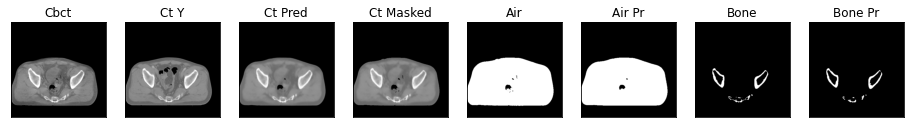

ssim score = 0.8797586560249329
psnr score = 24.59723472595215
snr score = 15.153715133666992
mae error = 0.020907390862703323
air dice score = 0.9978294947546142
bone dice score = 0.9076923076936474


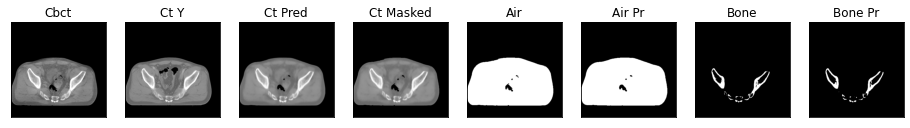

ssim score = 0.8841696977615356
psnr score = 24.87800407409668
snr score = 15.470067024230957
mae error = 0.020328015089035034
air dice score = 0.9968135999374903
bone dice score = 0.9094540612528701


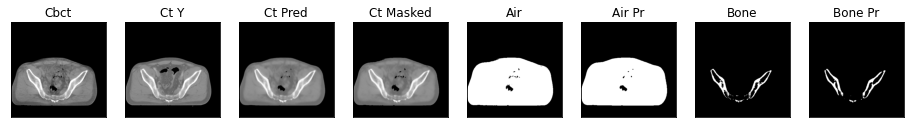

ssim score = 0.8859639763832092
psnr score = 25.614906311035156
snr score = 16.1452693939209
mae error = 0.019013987854123116
air dice score = 0.9970320192744186
bone dice score = 0.8950461796824091


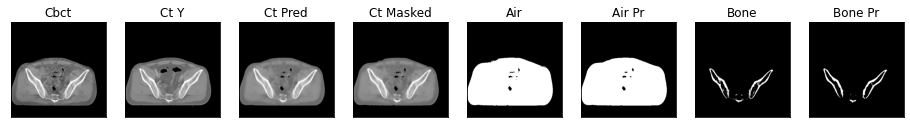

9it [00:34,  3.74s/it]

ssim score = 0.8827701807022095
psnr score = 25.29303550720215
snr score = 15.762137413024902
mae error = 0.019605612382292747
air dice score = 0.9961742564482324
bone dice score = 0.9005492917042418


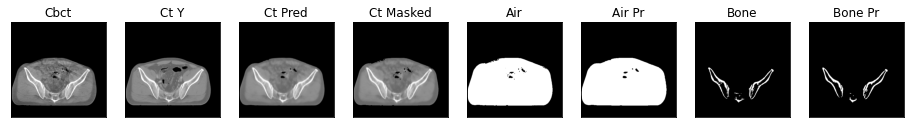

ssim score = 0.8223073482513428
psnr score = 22.56945037841797
snr score = 14.26675796508789
mae error = 0.029406918212771416
air dice score = 0.9989954676456877
bone dice score = 0.9715189873426735


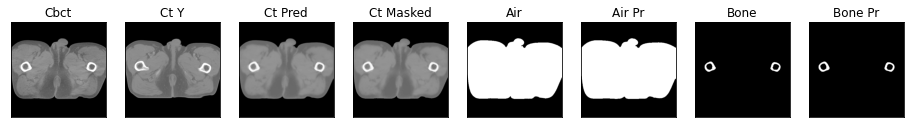

ssim score = 0.8123872876167297
psnr score = 22.22841453552246
snr score = 14.030012130737305
mae error = 0.030696991831064224
air dice score = 0.9990076594429826
bone dice score = 0.9637867122907389


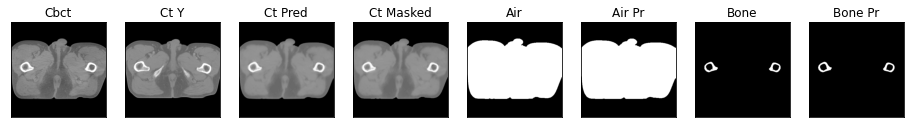

ssim score = 0.8061633110046387
psnr score = 21.97953987121582
snr score = 13.909095764160156
mae error = 0.03242207318544388
air dice score = 0.9989577534850124
bone dice score = 0.9333640765521475


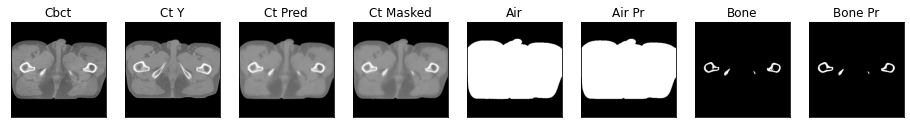

ssim score = 0.7985930442810059
psnr score = 21.741458892822266
snr score = 13.703303337097168
mae error = 0.032913174480199814
air dice score = 0.999049457718581
bone dice score = 0.9426517304808117


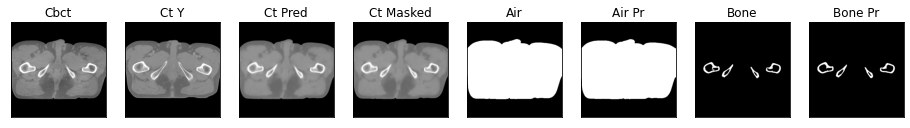

ssim score = 0.7905628085136414
psnr score = 21.626548767089844
snr score = 13.618630409240723
mae error = 0.033769603818655014
air dice score = 0.9988873517204846
bone dice score = 0.9178728248509046


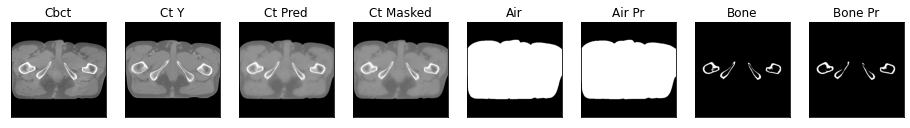

ssim score = 0.7833432555198669
psnr score = 21.52101707458496
snr score = 13.547514915466309
mae error = 0.03478219360113144
air dice score = 0.9987330337974973
bone dice score = 0.9262800740295145


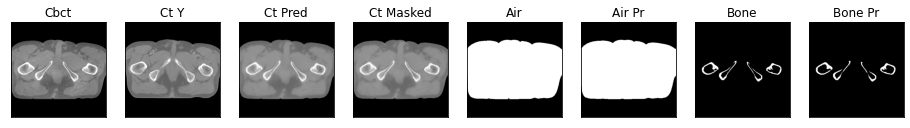

ssim score = 0.7761687636375427
psnr score = 21.21451187133789
snr score = 13.26131820678711
mae error = 0.0364421121776104
air dice score = 0.9987486989977905
bone dice score = 0.922720457953895


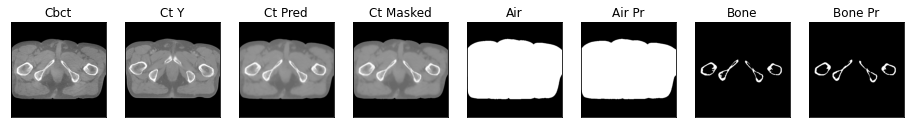

ssim score = 0.7744369506835938
psnr score = 21.250123977661133
snr score = 13.336004257202148
mae error = 0.03590422123670578
air dice score = 0.9989133228950019
bone dice score = 0.9158751696076544


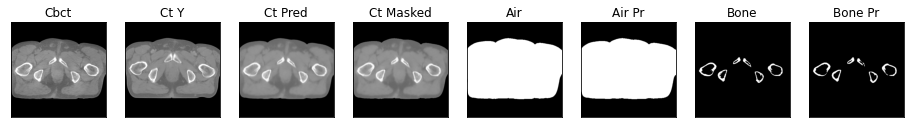

ssim score = 0.7742394804954529
psnr score = 21.394458770751953
snr score = 13.52901840209961
mae error = 0.0356026291847229
air dice score = 0.9989769492040671
bone dice score = 0.9266510049604979


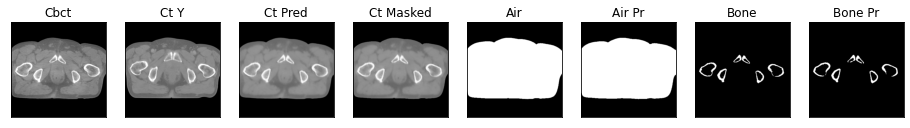

ssim score = 0.7676861882209778
psnr score = 21.25143814086914
snr score = 13.408609390258789
mae error = 0.037087149918079376
air dice score = 0.9990885614461497
bone dice score = 0.9263580479246474


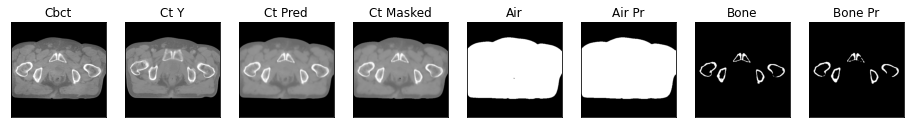

ssim score = 0.7547757625579834
psnr score = 21.166072845458984
snr score = 13.366022109985352
mae error = 0.038607314229011536
air dice score = 0.99901600591561
bone dice score = 0.9118755890679561


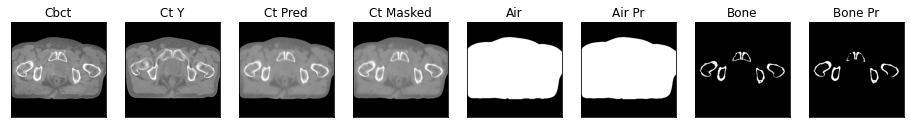

10it [00:37,  3.72s/it]

ssim score = 0.7548340559005737
psnr score = 21.19291114807129
snr score = 13.451199531555176
mae error = 0.038744255900382996
air dice score = 0.9990710204839989
bone dice score = 0.9086371527787691


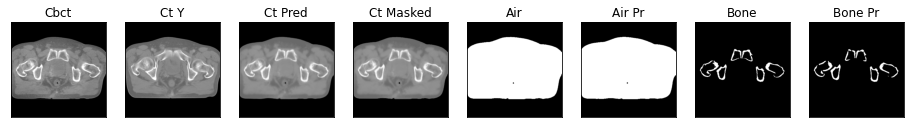

ssim score = 0.7472600936889648
psnr score = 20.91559410095215
snr score = 13.098511695861816
mae error = 0.04100614786148071
air dice score = 0.999153633001357
bone dice score = 0.8986486486496558


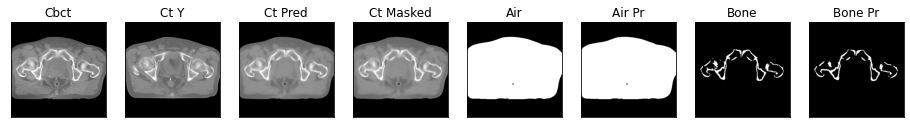

ssim score = 0.7514532804489136
psnr score = 20.781421661376953
snr score = 12.857121467590332
mae error = 0.041836321353912354
air dice score = 0.9989970840072587
bone dice score = 0.8731123749767297


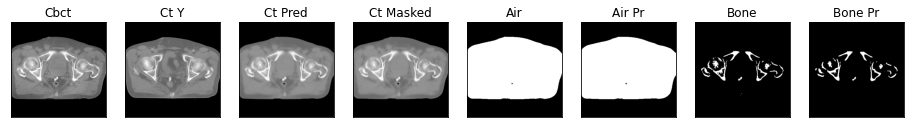

ssim score = 0.7652921676635742
psnr score = 20.978900909423828
snr score = 12.931510925292969
mae error = 0.04087679088115692
air dice score = 0.9990081379094337
bone dice score = 0.8283771440187924


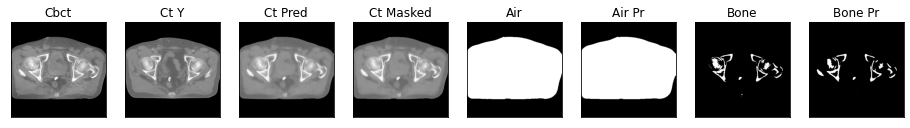

ssim score = 0.7702153921127319
psnr score = 21.18596076965332
snr score = 13.026142120361328
mae error = 0.0395270474255085
air dice score = 0.9988894767749482
bone dice score = 0.8385578260421679


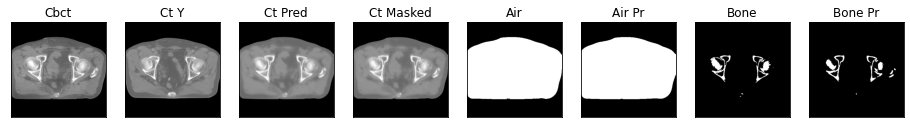

ssim score = 0.7688958644866943
psnr score = 21.463027954101562
snr score = 13.2525634765625
mae error = 0.036946479231119156
air dice score = 0.9989272388059708
bone dice score = 0.8709815687969247


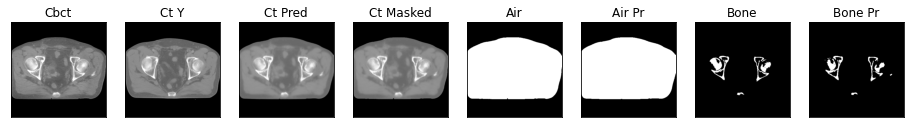

ssim score = 0.7661024928092957
psnr score = 21.26068115234375
snr score = 13.082369804382324
mae error = 0.03814429044723511
air dice score = 0.9989411675236781
bone dice score = 0.8873223676861661


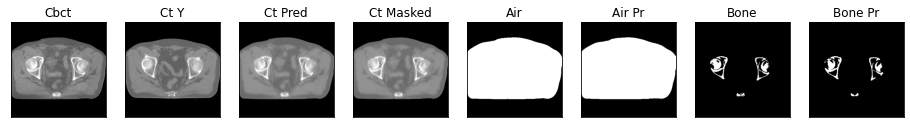

ssim score = 0.7646098732948303
psnr score = 21.00323486328125
snr score = 12.838400840759277
mae error = 0.03946293890476227
air dice score = 0.9989543067288605
bone dice score = 0.8949209796128009


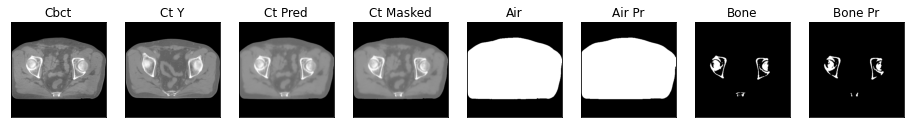

ssim score = 0.7621350288391113
psnr score = 20.69930648803711
snr score = 12.39297866821289
mae error = 0.04091596603393555
air dice score = 0.9986473954980133
bone dice score = 0.9169435215956697


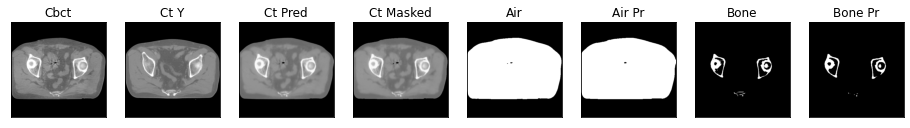

ssim score = 0.7715153098106384
psnr score = 20.815935134887695
snr score = 12.450302124023438
mae error = 0.040073148906230927
air dice score = 0.9991925333080015
bone dice score = 0.9270292429635553


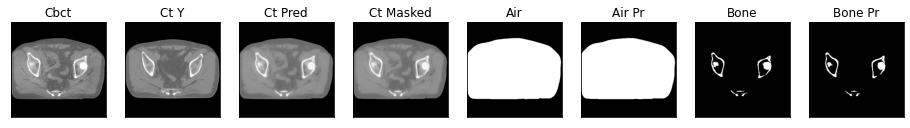

ssim score = 0.7719571590423584
psnr score = 21.11501693725586
snr score = 12.775029182434082
mae error = 0.037953734397888184
air dice score = 0.9990869650838744
bone dice score = 0.8989361702146859


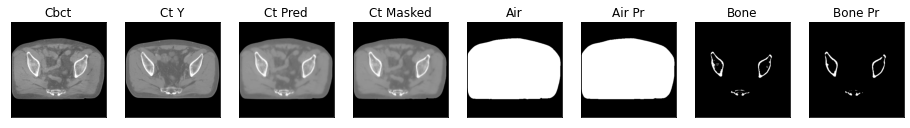

ssim score = 0.7669578790664673
psnr score = 21.004192352294922
snr score = 12.737018585205078
mae error = 0.03825030103325844
air dice score = 0.998895147053526
bone dice score = 0.9063776869798121


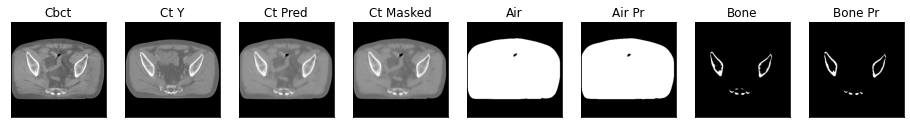

11it [00:41,  3.72s/it]

ssim score = 0.760140597820282
psnr score = 20.672388076782227
snr score = 12.534444808959961
mae error = 0.040267642587423325
air dice score = 0.99878544711861
bone dice score = 0.9138466568593453


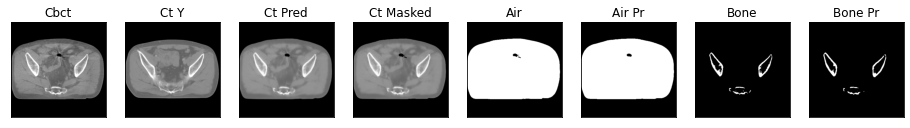

ssim score = 0.7516505718231201
psnr score = 20.517072677612305
snr score = 12.413087844848633
mae error = 0.04095152020454407
air dice score = 0.998887625901905
bone dice score = 0.9102660453944046


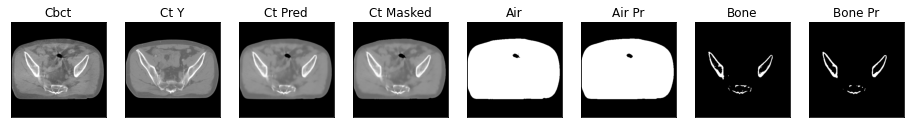

ssim score = 0.7430315017700195
psnr score = 20.570026397705078
snr score = 12.436254501342773
mae error = 0.041293997317552567
air dice score = 0.998994288779311
bone dice score = 0.8995934458556167


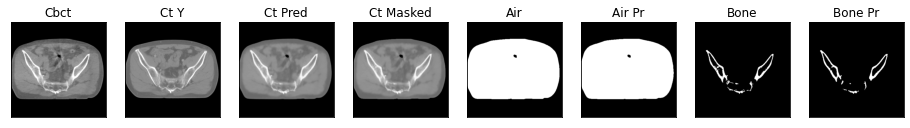

ssim score = 0.7416152358055115
psnr score = 20.781444549560547
snr score = 12.584297180175781
mae error = 0.04027210921049118
air dice score = 0.9989856648783415
bone dice score = 0.8960971827358994


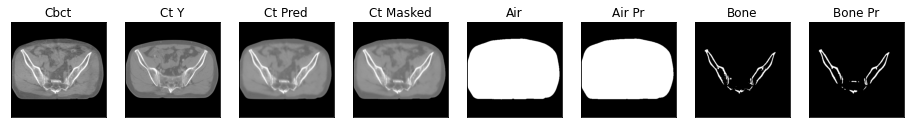

ssim score = 0.8602767586708069
psnr score = 24.118602752685547
snr score = 15.595993995666504
mae error = 0.02517729625105858
air dice score = 0.9984458876083949
bone dice score = 0.89383978573297


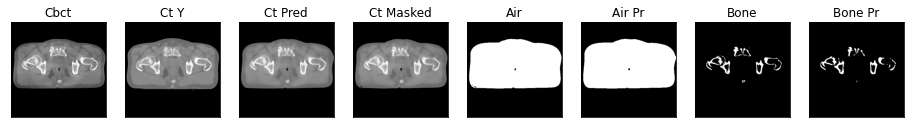

ssim score = 0.8622621297836304
psnr score = 24.294984817504883
snr score = 15.81238842010498
mae error = 0.024404341354966164
air dice score = 0.998826573594898
bone dice score = 0.8795288695444946


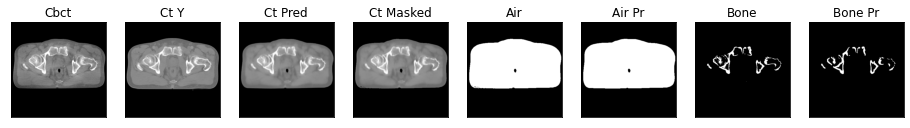

ssim score = 0.8616635203361511
psnr score = 24.457813262939453
snr score = 15.983003616333008
mae error = 0.02462700940668583
air dice score = 0.9987201300950125
bone dice score = 0.8488702476004752


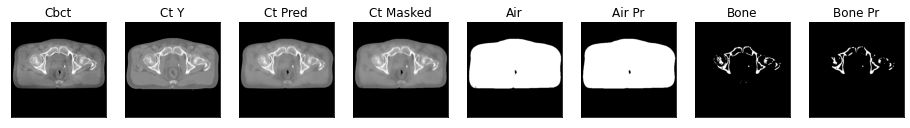

ssim score = 0.8643127679824829
psnr score = 24.499168395996094
snr score = 15.965938568115234
mae error = 0.023544372990727425
air dice score = 0.9986479443466711
bone dice score = 0.8551478989481383


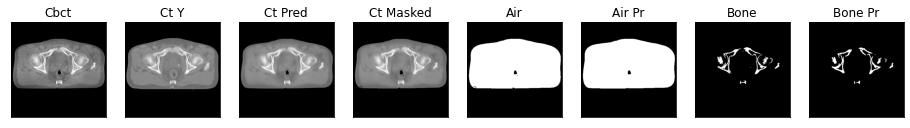

ssim score = 0.8689982295036316
psnr score = 24.660804748535156
snr score = 15.97195053100586
mae error = 0.02187730371952057
air dice score = 0.9983790089230269
bone dice score = 0.8540850165834476


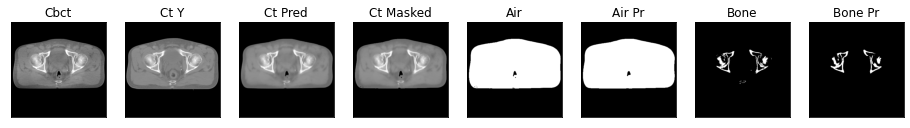

ssim score = 0.873094379901886
psnr score = 24.867385864257812
snr score = 16.157730102539062
mae error = 0.02141566015779972
air dice score = 0.9987009731306558
bone dice score = 0.8780557134752977


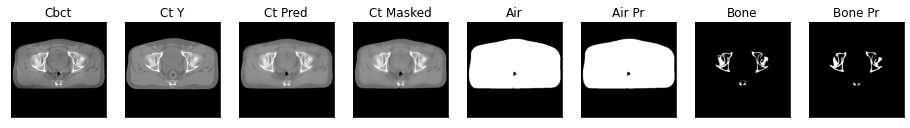

ssim score = 0.8727365136146545
psnr score = 24.799240112304688
snr score = 16.07395362854004
mae error = 0.02167270891368389
air dice score = 0.998406562826408
bone dice score = 0.8837792642156664


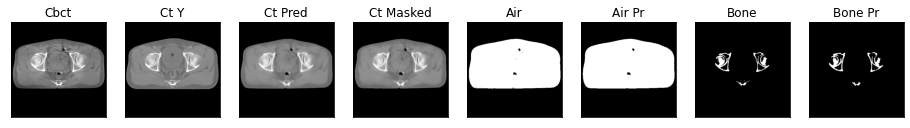

ssim score = 0.8677265644073486
psnr score = 24.13709259033203
snr score = 15.42116928100586
mae error = 0.022916920483112335
air dice score = 0.9981229361874933
bone dice score = 0.8898269311961471


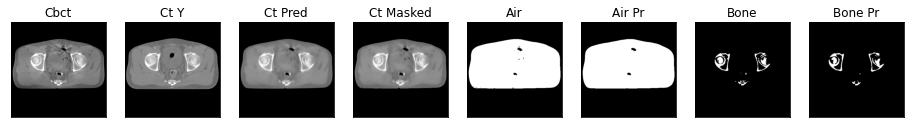

12it [00:45,  3.71s/it]

ssim score = 0.8638829588890076
psnr score = 24.116352081298828
snr score = 15.456210136413574
mae error = 0.02371338941156864
air dice score = 0.9970761583798862
bone dice score = 0.916393442624093


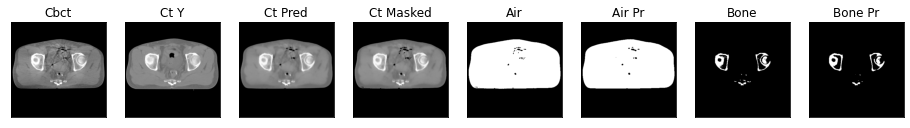

ssim score = 0.8638347387313843
psnr score = 23.737621307373047
snr score = 15.055550575256348
mae error = 0.02437799610197544
air dice score = 0.9968884485587813
bone dice score = 0.9168893263968937


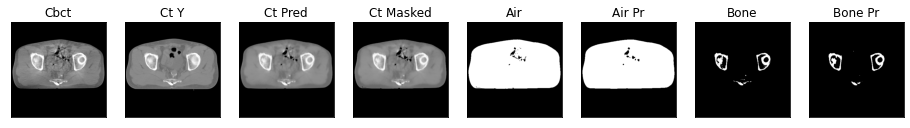

ssim score = 0.864443838596344
psnr score = 23.005962371826172
snr score = 14.253118515014648
mae error = 0.025162603706121445
air dice score = 0.9968003976204923
bone dice score = 0.8891715694086632


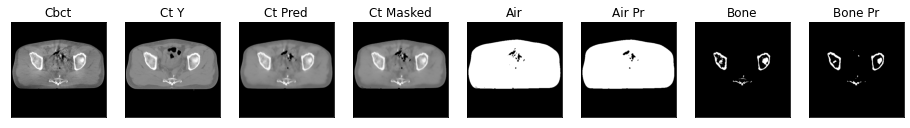

ssim score = 0.8659547567367554
psnr score = 23.434438705444336
snr score = 14.637699127197266
mae error = 0.024217749014496803
air dice score = 0.9975021720243286
bone dice score = 0.8946401736534539


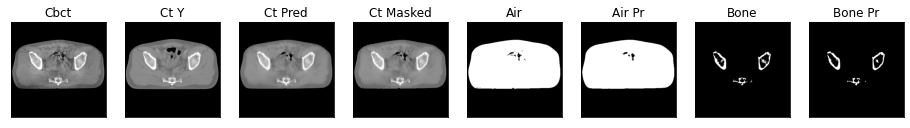

ssim score = 0.8685362935066223
psnr score = 23.74654769897461
snr score = 14.948712348937988
mae error = 0.023685690015554428
air dice score = 0.9976264037292718
bone dice score = 0.9010450685842416


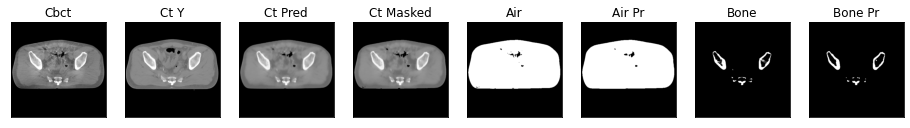

ssim score = 0.8645219802856445
psnr score = 23.67365074157715
snr score = 14.889172554016113
mae error = 0.024131979793310165
air dice score = 0.997153008164516
bone dice score = 0.908408877775736


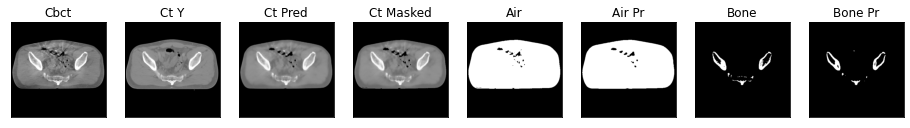

ssim score = 0.8613710999488831
psnr score = 23.64255142211914
snr score = 14.913277626037598
mae error = 0.024598650634288788
air dice score = 0.9971646399092707
bone dice score = 0.9202898550734953


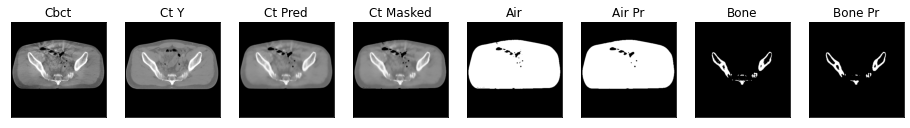

ssim score = 0.862399697303772
psnr score = 23.18265724182129
snr score = 14.472750663757324
mae error = 0.02519255317747593
air dice score = 0.9974607280297793
bone dice score = 0.9141427442729241


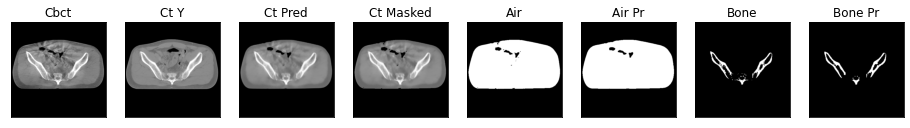

ssim score = 0.8666345477104187
psnr score = 23.305400848388672
snr score = 14.540759086608887
mae error = 0.024522392079234123
air dice score = 0.9973507845147068
bone dice score = 0.896836705615605


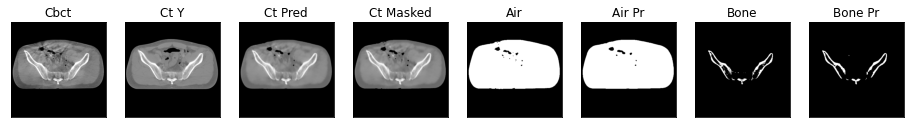

ssim score = 0.8665938377380371
psnr score = 23.610721588134766
snr score = 14.809724807739258
mae error = 0.023982452228665352
air dice score = 0.9976323262198258
bone dice score = 0.8812642369037406


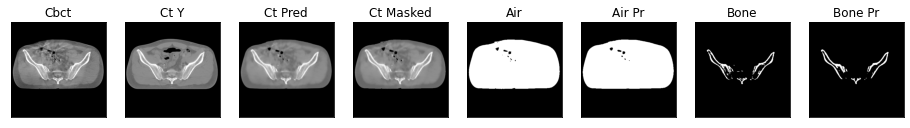

ssim score = 0.870642900466919
psnr score = 23.82370948791504
snr score = 15.022787094116211
mae error = 0.023249339312314987
air dice score = 0.9977341389728115
bone dice score = 0.8880348449924669


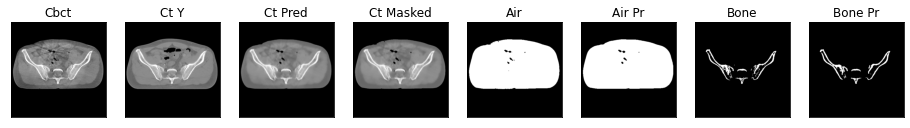

ssim score = 0.8696083426475525
psnr score = 23.899444580078125
snr score = 15.097098350524902
mae error = 0.023316258564591408
air dice score = 0.9977610292958297
bone dice score = 0.8844012944998783


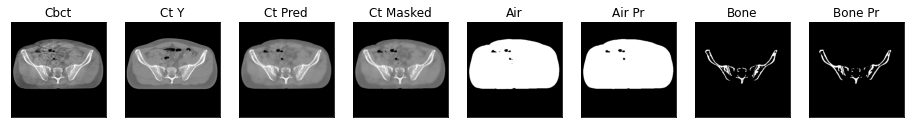

13it [00:48,  3.70s/it]

ssim score = 0.8602465987205505
psnr score = 23.185121536254883
snr score = 14.387816429138184
mae error = 0.025002935901284218
air dice score = 0.9970321700074616
bone dice score = 0.876781002640148


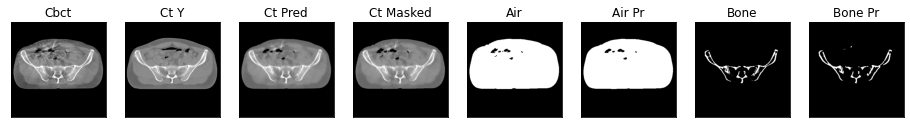

ssim score = 0.8546150922775269
psnr score = 22.653533935546875
snr score = 13.838953971862793
mae error = 0.026514563709497452
air dice score = 0.9967067926398441
bone dice score = 0.8734110169508288


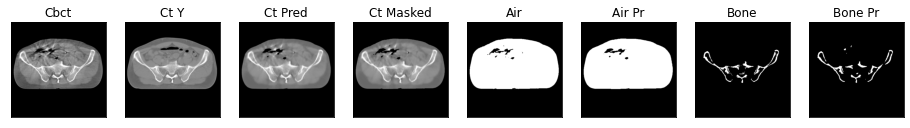

ssim score = 0.8513628840446472
psnr score = 22.3747615814209
snr score = 13.541556358337402
mae error = 0.027485573664307594
air dice score = 0.9965438434705933
bone dice score = 0.8599899091844098


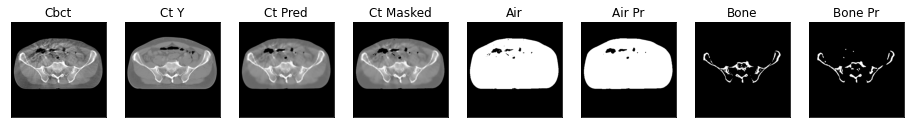

ssim score = 0.839961588382721
psnr score = 21.91448402404785
snr score = 13.035344123840332
mae error = 0.02920120395720005
air dice score = 0.9964911715945883
bone dice score = 0.8462974486640162


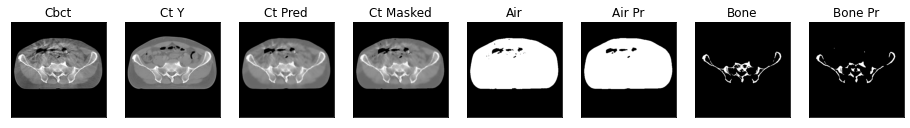

ssim score = 0.8342292308807373
psnr score = 21.819259643554688
snr score = 12.886322021484375
mae error = 0.029831677675247192
air dice score = 0.9969894631209256
bone dice score = 0.8783017730083427


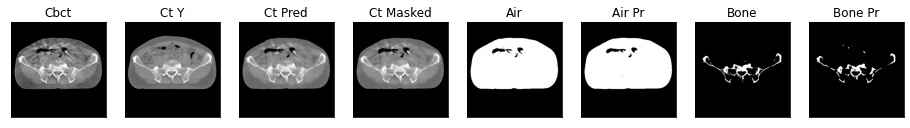

ssim score = 0.8256473541259766
psnr score = 21.45366668701172
snr score = 12.551188468933105
mae error = 0.03152206912636757
air dice score = 0.996833438885373
bone dice score = 0.8901612526304024


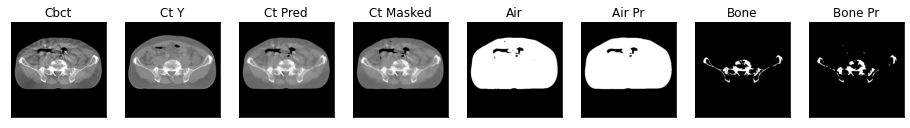

ssim score = 0.8197358250617981
psnr score = 21.193849563598633
snr score = 12.236146926879883
mae error = 0.03181878477334976
air dice score = 0.9972916039723164
bone dice score = 0.8753523716156961


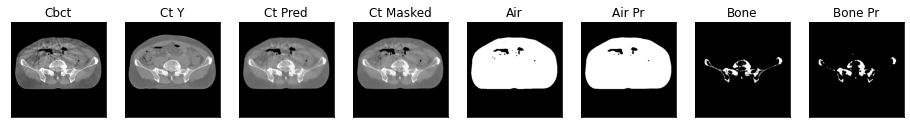

ssim score = 0.8313462138175964
psnr score = 21.985605239868164
snr score = 12.88037109375
mae error = 0.028902003541588783
air dice score = 0.9974668333793437
bone dice score = 0.8937757201659751


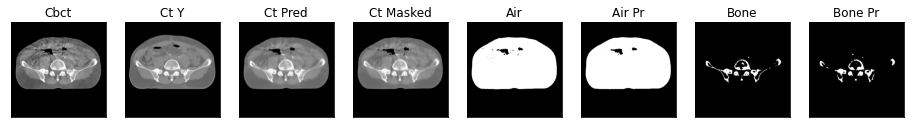

ssim score = 0.8873819708824158
psnr score = 27.060699462890625
snr score = 17.441612243652344
mae error = 0.016219833865761757
air dice score = 0.9991932833368198
bone dice score = 0.9433551198272506


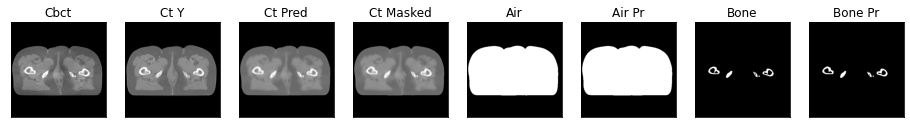

ssim score = 0.8870936036109924
psnr score = 27.18233299255371
snr score = 17.68425750732422
mae error = 0.016329951584339142
air dice score = 0.9991612917591355
bone dice score = 0.9401864907905347


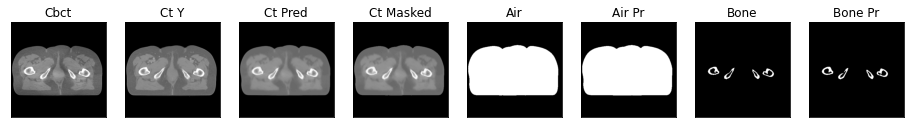

ssim score = 0.8842684030532837
psnr score = 27.12375831604004
snr score = 17.708599090576172
mae error = 0.016667770221829414
air dice score = 0.9990188484379041
bone dice score = 0.9205559012669455


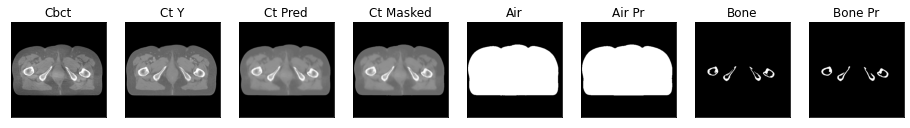

ssim score = 0.8821472525596619
psnr score = 27.087535858154297
snr score = 17.735820770263672
mae error = 0.01694401353597641
air dice score = 0.9988473087964297
bone dice score = 0.9246791891403259


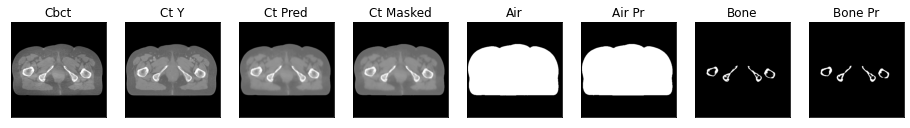

14it [00:52,  3.70s/it]

ssim score = 0.8810702562332153
psnr score = 26.88827133178711
snr score = 17.565019607543945
mae error = 0.017395921051502228
air dice score = 0.9988877343441299
bone dice score = 0.9263531499569414


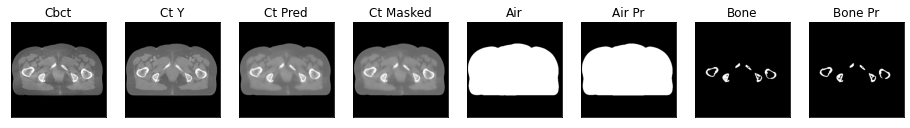

ssim score = 0.8820415735244751
psnr score = 26.856290817260742
snr score = 17.555992126464844
mae error = 0.01708308793604374
air dice score = 0.9988394922961273
bone dice score = 0.926203991944219


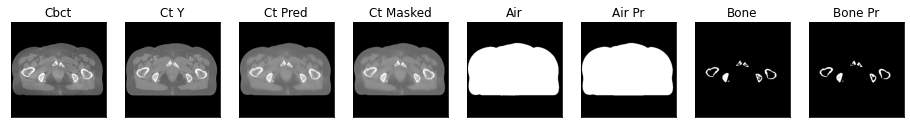

ssim score = 0.8795772194862366
psnr score = 26.779394149780273
snr score = 17.510421752929688
mae error = 0.017387041822075844
air dice score = 0.9989368673996949
bone dice score = 0.906490649066621


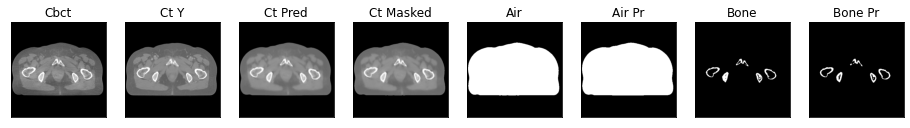

ssim score = 0.8783831596374512
psnr score = 26.366497039794922
snr score = 17.145889282226562
mae error = 0.01819724217057228
air dice score = 0.9987257065047231
bone dice score = 0.913750441853769


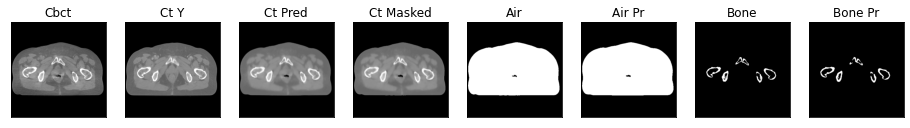

ssim score = 0.87950599193573
psnr score = 26.081680297851562
snr score = 16.903818130493164
mae error = 0.01827266253530979
air dice score = 0.9987325544127511
bone dice score = 0.9093320072947235


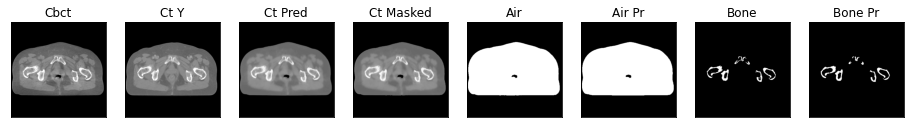

ssim score = 0.8775509595870972
psnr score = 25.96031951904297
snr score = 16.870159149169922
mae error = 0.018551377579569817
air dice score = 0.9987250380667215
bone dice score = 0.9006868918159604


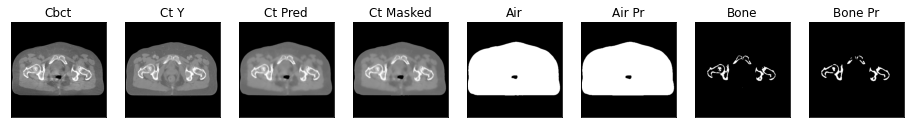

ssim score = 0.8808170557022095
psnr score = 27.03080940246582
snr score = 18.053922653198242
mae error = 0.017766164615750313
air dice score = 0.9987526650905777
bone dice score = 0.9043394869347356


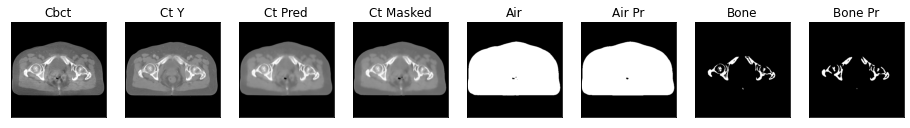

ssim score = 0.8820303678512573
psnr score = 26.155834197998047
snr score = 17.05039405822754
mae error = 0.017931846901774406
air dice score = 0.9984221280184994
bone dice score = 0.8792221084974544


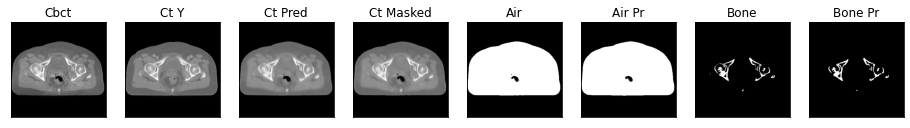

ssim score = 0.8838708400726318
psnr score = 26.319143295288086
snr score = 17.10428237915039
mae error = 0.017523348331451416
air dice score = 0.9984166412457703
bone dice score = 0.8676671214214058


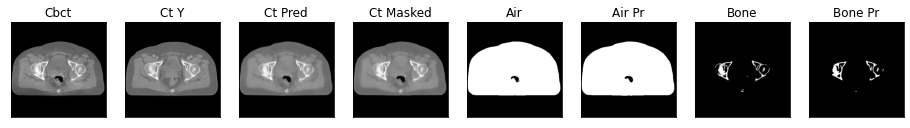

ssim score = 0.8856789469718933
psnr score = 26.20582389831543
snr score = 16.963836669921875
mae error = 0.018258582800626755
air dice score = 0.998581519221863
bone dice score = 0.889586603874244


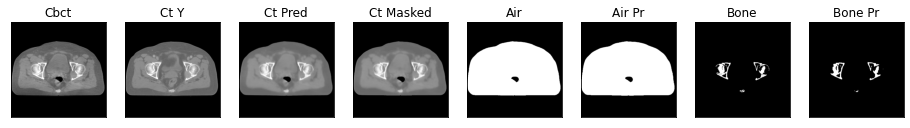

ssim score = 0.8885039687156677
psnr score = 26.829660415649414
snr score = 17.579666137695312
mae error = 0.018327033147215843
air dice score = 0.998658623187887
bone dice score = 0.906296976784595


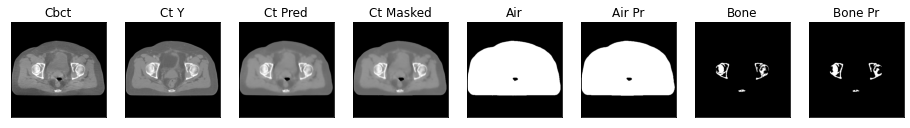

ssim score = 0.8881534337997437
psnr score = 27.772212982177734
snr score = 18.556447982788086
mae error = 0.016906077042222023
air dice score = 0.9986288620976288
bone dice score = 0.9245757385304121


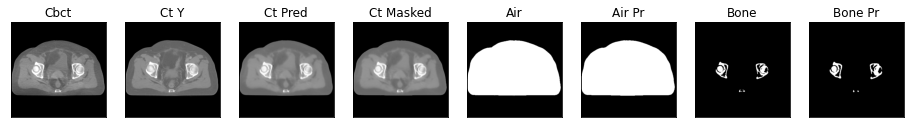

15it [00:56,  3.70s/it]

ssim score = 0.8826120495796204
psnr score = 27.141401290893555
snr score = 17.977127075195312
mae error = 0.017648180946707726
air dice score = 0.9986955203463579
bone dice score = 0.9427091508406418


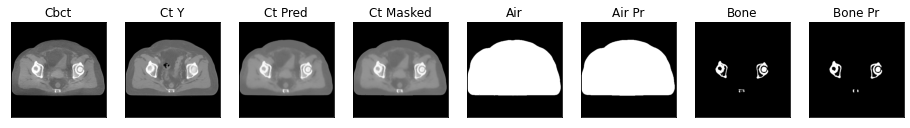

ssim score = 0.8705062866210938
psnr score = 26.00251007080078
snr score = 16.875795364379883
mae error = 0.0192487183958292
air dice score = 0.9986505100792223
bone dice score = 0.9409137753359513


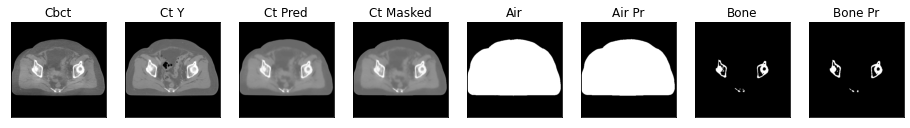

ssim score = 0.8556332588195801
psnr score = 24.252056121826172
snr score = 15.052906036376953
mae error = 0.021938592195510864
air dice score = 0.9981285524457537
bone dice score = 0.9194690265504543


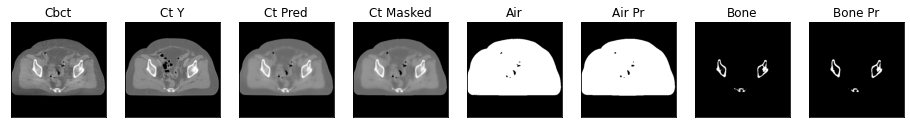

ssim score = 0.8487541675567627
psnr score = 23.879758834838867
snr score = 14.662616729736328
mae error = 0.023089906200766563
air dice score = 0.9979509331561182
bone dice score = 0.9243243243260287


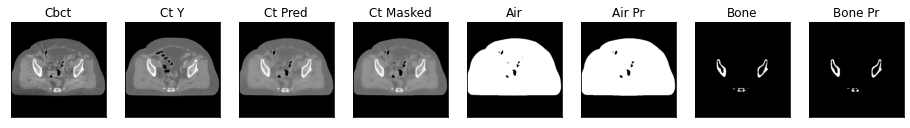

ssim score = 0.8479520678520203
psnr score = 24.5059814453125
snr score = 15.353752136230469
mae error = 0.02256571687757969
air dice score = 0.9978494918225914
bone dice score = 0.9309217694501869


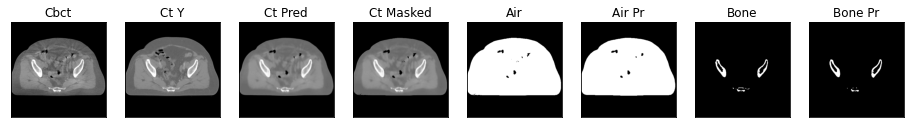

ssim score = 0.8480585217475891
psnr score = 24.6651668548584
snr score = 15.568033218383789
mae error = 0.022457445040345192
air dice score = 0.9978814710196114
bone dice score = 0.923651297369355


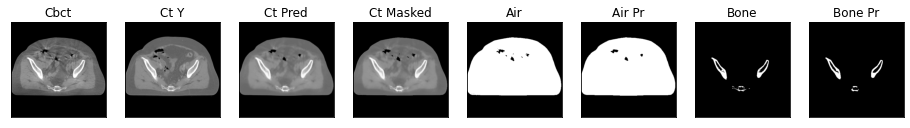

ssim score = 0.844005286693573
psnr score = 23.880996704101562
snr score = 14.84829330444336
mae error = 0.02407826855778694
air dice score = 0.9979091453043183
bone dice score = 0.9204811748176772


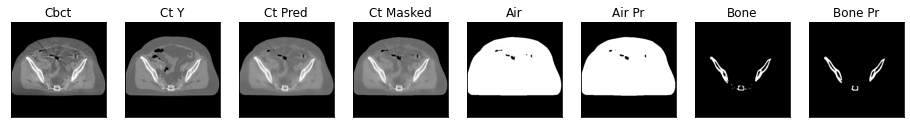

ssim score = 0.8443105816841125
psnr score = 23.817014694213867
snr score = 14.857168197631836
mae error = 0.024498729035258293
air dice score = 0.9976323704973372
bone dice score = 0.9005266237580379


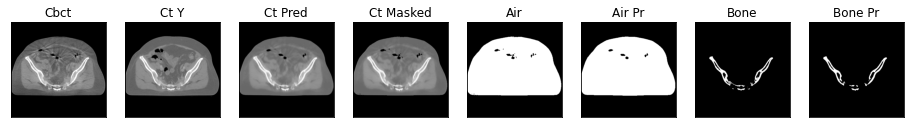

ssim score = 0.8423957824707031
psnr score = 23.65863609313965
snr score = 14.694499969482422
mae error = 0.024990707635879517
air dice score = 0.9976898279616884
bone dice score = 0.9090909090922251


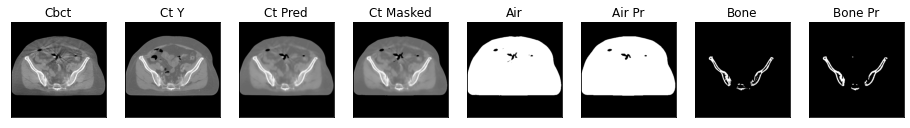

ssim score = 0.8414133191108704
psnr score = 23.7755126953125
snr score = 14.789198875427246
mae error = 0.024733828380703926
air dice score = 0.9975715922107691
bone dice score = 0.9045711918256516


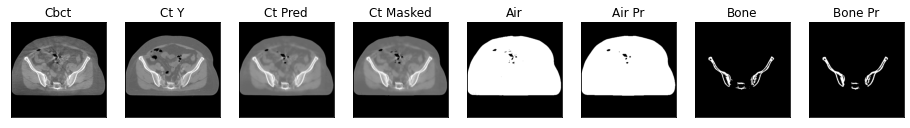

ssim score = 0.8485447764396667
psnr score = 24.6163330078125
snr score = 15.641654968261719
mae error = 0.023102164268493652
air dice score = 0.9981929466627817
bone dice score = 0.890803743873261


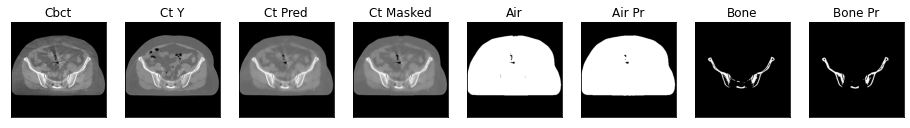

16it [00:59,  3.73s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

16it [00:05,  2.93it/s]


(0.853621244430542,
 23.957109808921814,
 14.978104829788208,
 0.02467847499065101,
 0.9968617856143094,
 0.908446331329785,
 0.5)

In [38]:
# import torchvision.models as models
# models.vgg16(pretrained=True)